# 測試資料 


## boston-側連續數值演算法


In [32]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
boston=datasets.load_boston()
X=boston.data
Y=boston.target
#將資料分成訓練、測試集 其中測試集佔三成
XX_train, XX_test, YY_train, YY_test =train_test_split(X,Y,test_size=0.3,random_state=1)

## iris-測分類演算法用

In [33]:
iris = datasets.load_iris()
xx=iris.data
typeY=iris.target
from sklearn.cross_validation import train_test_split
#將資料分成訓練、測試集 其中測試集佔三成
xx_train, xx_test, Y_train, Y_test =train_test_split(xx,typeY,test_size=0.3,random_state=1)

# 載入資料

In [117]:
import pymongo
client=pymongo.MongoClient('192.168.1.113',27017,username="j122085",password="850605")
db=client.rawData
print(db.collection_names())
collection=db.wowprimediendata
# wowDatas=list(collection.find({"ADGC_weekday":{"$gte":0},"avgDailyNet":{"$gte":0},"costPower_Analyze":{"$gte":0}}))
wowDatas=list(collection.find({"ADGC_weekday":{"$gte":0},"avgDailyNet":{"$gte":0},"costPower_Analyze":{"$gte":0},'Called':'石二鍋'}))

['Watsons', 'pxmart', 'busData', 'HRdata104', 'wowprimediendata', 'info591', 'departmentStore', 'websites591', 'carrefour', 'taiwanInfo', 'smallStyleCount', 'addressCoordinate', 'Nhuman', 'ipeenWebsite', 'bigStyleCount', 'ipeenInfo', 'conStore', 'CostPower']


In [118]:
wowDatas=[i for i in wowDatas if i['NcostData_Analyze']>1 and "家樂" not in i['StoreName'] and "大潤" not in i['StoreName']]

In [119]:
wowDatas

[{'ADGC_holiday': 364,
  'ADGC_weekday': 162,
  'Address': '台中市太平區中山路四段169號',
  'AreaManager': '陳紀妍',
  'Called': '石二鍋',
  'CareerName': '石二鍋事業處',
  'CareerNo': '112',
  'Chef': '魏丞賢',
  'CloseDate': 'None',
  'CodeId': 'B',
  'CorporationId': '25156459',
  'Corporation_ch': '石二鍋太平中山分公司',
  'CreateDate': '2018-03-01 10:22:45.540000',
  'ItemName': '百貨點',
  'Manager': '王益珊',
  'NbusStation_Analyze': 8,
  'Ncarrefour_Analyze': 0,
  'NconStore_Analyze': 3,
  'NcostData_Analyze': 2,
  'Nhuman_Analyze': 12346,
  'Njob_Analyze': 13,
  'Nken_Analyze': 0,
  'Nmc_Analyze': 0,
  'Npxmart_Analyze': 0,
  'NsimCostDien': 4,
  'Nstar_Analyze': 0,
  'Nwa_Analyze': 0,
  'Nwatson_Analyze': 0,
  'Phone': '04-23958847',
  'PlaceNo': '49',
  'StoreName': '太平中山',
  'StoreNo': '11203',
  '_id': '11203',
  'areaRadius_Analyze': 500,
  'avgCost_Analyze': 63.0,
  'avgDailyCustomer': 224,
  'avgDailyMeal': 212,
  'avgDailyNet': 53907,
  'avgSalary_Analyze': 29200.0,
  'bigadd': '台中市',
  'costPower_Analyze': 86.

In [120]:
df['costPower_Analyze'].values

df['Nhuman_Analyze'].values

array([11943, 17700, 37422, 35880,  7974, 12000], dtype=int64)

In [121]:
import numpy as np
import pandas as pd
df=pd.DataFrame(wowDatas)
df.salary = df.avgDailyCustomer.astype(float)                   #traform into float type
df.working = df.avgDailyNet.astype(float)                 #traform into float type
X = df[['costPower_Analyze','Nhuman_Analyze',"NsimCostDien",
        'NbusStation_Analyze','NconStore_Analyze','Nstar_Analyze',
        'Nmc_Analyze', 'Nken_Analyze','Nwa_Analyze',
        'Nwatson_Analyze','Npxmart_Analyze','Ncarrefour_Analyze']].values                   #tranform DataFrame to ndarray Matrix  為了predict輸入的方式
# xx=X
#將每個欄位的數值都變成0-1(除以最大的數做正規化、並只留下該數值List) 
# x=[]
# for i in range(len(X.T)):
#     x.append(X.T[i]/max(X.T[i]))

#用zscore正規化
x=[]
def zscore(x, axis = None):
    x=np.array(x)
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore    

for i in range(len(X.T)):
    x.append(zscore(X.T[i]))

x=np.array(x)
xx=x.T

Y=df['ADGC_weekday'].values


#分類
Calls=set(i["Called"] for i in wowDatas)
for Call in Calls:
    mean=np.mean([i["ADGC_weekday"] for i in wowDatas if i["Called"]==Call and 'ADGC_weekday' in i])
    if not np.isnan(mean):
        for j in wowDatas:
            if j["Called"]==Call and 'ADGC_weekday' in j:
                if j["ADGC_weekday"]>mean*1.15:
                    j['type']=0#"good"
                elif j["ADGC_weekday"]<mean*0.85:
                    j['type']=2#"bad"
                else:
                    j['type']=1#"normal"
            if 'avgDailyCustomer' in j:
                aC=j["avgDailyNet"]/j["avgDailyCustomer"]
                if aC<290:
                    j['typeP']="低"
                elif aC<450:
                    j['typeP']="中"
                elif aC<800:
                    j['typeP']="中高"
                else:
                    j['typeP']="高"
                    
typeY= np.array([i['type'] for i in wowDatas if 'NbusStation_Analyze' in i and 'ADGC_weekday' in i and 'costPower_Analyze' in i
            ])

# xx為zscore正規化資料 
# X為原始資料

#### 都為262筆8維度

# Y為平均來客數>>(訓練預測數值)
# typeY為店家來客數表現>>(訓練預測類型)

In [122]:
xx.shape,X.shape

((28, 12), (28, 12))

In [123]:
Y.shape,Y

((28,), array([162, 180, 146, 199, 221, 163, 188, 223, 281, 267, 203, 231, 297,
        159, 307, 252, 250, 144, 212, 200, 287, 388, 237, 329, 256, 219,
        340, 380], dtype=int64))

In [124]:
typeY.shape,typeY

((28,),
 array([2, 2, 2, 2, 1, 2, 2, 1, 0, 1, 2, 1, 0, 2, 0, 1, 1, 2, 1, 2, 0, 0,
        1, 0, 1, 1, 0, 0]))

# 表現好的店家資料(GoodData)
#### newDataXG為原始資料 newDataxxG為正規化後的資料

In [125]:
bestData="""74	247984	9	89	8	6	1	2
52	137707	10	78	0	2	0	0
76	355419	10	287	31	15	5	1
54	382333	16	203	9	4	2	3
54	286210	14	136	0	2	2	0
77	238522	10	96	8	7	1	2
57	229368	28	122	2	4	4	0
52	99568	0	45	3	5	2	0
56	365344	8	184	9	6	3	3
63	282141	22	187	16	15	2	1"""

newDataXG=np.array([[int(j)for j in i.split("\t")] for i in bestData.split('\n')])

newDataxxG=[]
for i in range(len(newDataXG.T)):
    newDataxxG.append(zscore(newDataXG.T[i]))
newDataxxG=np.array(newDataxxG).T

YG=np.array([int(s) for s in """389
393
394
397
399
414
424
430
460
512""".split("\n")])

# 表現差的店家資料(BadData)
#### newDataXB為原始資料 newDataxxB為正規化後的資料



In [126]:
badData="""56	178949	12	125	5	8	5	3
70	353804	11	252	33	14	4	2
64	233683	13	154	11	7	3	1
67	373797	11	229	34	16	2	3
60	185182	42	134	4	7	4	1
52	102316	0	49	3	5	2	0
51	106274	7	39	1	2	2	0
65	342102	20	171	13	12	3	2
52	292044	8	124	8	6	1	0
58	185640	39	132	4	6	3	1"""


newDataXB=np.array([[int(j)for j in i.split("\t")] for i in badData.split('\n')])

newDataxxB=[]
for i in range(len(newDataXB.T)):
    newDataxxB.append(zscore(newDataXB.T[i]))
newDataxxB=np.array(newDataxxB).T
YB=np.array([int(s) for s in """81
87
93
95
96
97
98
98
101
104""".split("\n")])

# ====================預測數值====================

In [127]:
from sklearn.cross_validation import train_test_split
XX_train, XX_test, YY_train, YY_test =train_test_split(X,Y,test_size=0.3,random_state=1)

In [128]:
#畫圖用
import matplotlib.pyplot as plt
def plotPaint(predict,Y,R=0,title=""):
    plt.scatter(predict,Y,s=2)
    if R==1:
        plt.plot(predict, predict, 'ro')
#         plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Measured')
    plt.show()

# 引入sklearn模型

# 試跑LinearRegression

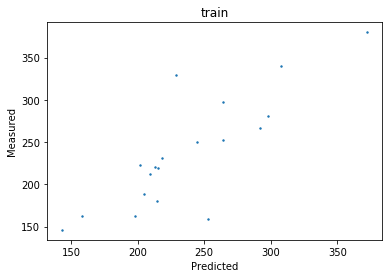

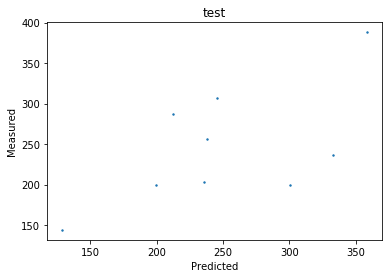

In [129]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(XX_train, YY_train)
# features="消費力	人口數	公車站數	四大超商數	星巴克數	麥當勞數	肯德基數	瓦城數".split("\t")

# print("參數")
# for i,j in zip(features,lm.coef_):
#     print(i,j)

    
    
predict=lm.predict(XX_train)
plotPaint(predict,YY_train,title="train")
predict=lm.predict(XX_test)
plotPaint(predict,YY_test,title="test")

In [130]:
# predicted_sales = lm.predict(newDataXG)
# print("好店家預測")
# print(predicted_sales)

# predicted_sales = lm.predict(newDataXB)
# print("差店家預測")
# print(predicted_sales)

# 試跑SVR

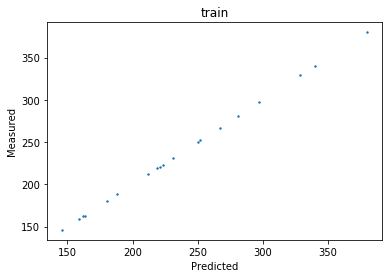

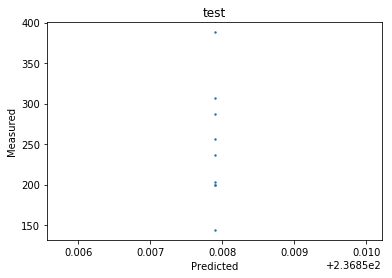

In [131]:

from sklearn import datasets
from sklearn.svm import SVR
import matplotlib.pyplot as plt
clf = SVR(kernel='rbf', C=1e3, gamma=0.1)
clf.fit(XX_train, YY_train)
# predicted_sales = clf.predict(newDataXG)
# print("好店家預測")
# print(predicted_sales)

# predicted_sales = clf.predict(newDataXB)
# print("差店家預測")
# print(predicted_sales)

predict=clf.predict(XX_train)
plotPaint(predict,YY_train,title="train")
predict=clf.predict(XX_test)
plotPaint(predict,YY_test,title="test")

In [132]:
# predict=clf.predict(newDataXB)
# plotPaint(predict,YB,R=1)

In [133]:
# predict=clf.predict(newDataXG)
# plotPaint(predict,YG,R=1)

In [134]:
# TryData="""63	333451	13	148	10	8	2	2
# 62	205551	12	127	2	5	3	1
# 58	174562	26	128	4	6	3	1
# 72	137555	12	100	4	9	1	1
# 79	223146	12	128	11	12	2	2
# 63	282141	22	187	16	15	2	1
# 52	157180	4	83	5	4	2	1
# 71	128373	8	52	1	3	3	0"""

# #"消費力	人口數	公車站數	四大超商數	星巴克數	麥當勞數	肯德基數	瓦城數"
# newDataXTry=np.array([[int(j) for j in i.split("\t")] for i in TryData.split('\n')])


# newDataxxTry=[]
# for i in range(len(newDataXTry.T)):
#     newDataxxTry.append(zscore(newDataXTry.T[i]))
# newDataxxTry=np.array(newDataxxTry).T


# clf.predict(newDataXTry)


# 引入keras模型

In [135]:
# from keras.datasets import mnist
from keras.models import Sequential # 序慣模型(可一層一層加入)
from keras.layers.core import Dense,Activation # 緊密層、啟動函數
from keras.layers import Dropout #減少overfitting的方法
from keras.utils import np_utils #one-hot 僅分類時使用

# 淺層神經網路(NN)

In [136]:
input_size=len(XX_train[0])#feature數量
batch_size=50#每批樣本大小
epochs=500#處理幾輪

model=Sequential()  #定義model
model.add(Dense(40,input_dim=input_size)) #加入層(緊密層) 產出個數40 輸入個數8 次元
model.add(Activation('relu')) #啟動函數
# model.add(Dense(3))  
# model.add(Activation('linear')) #啟動函數
model.add(Dense(1))  
model.add(Activation('linear')) #啟動函數

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
train_history=model.fit(XX_train,YY_train,batch_size=batch_size,epochs=epochs,validation_split=0.2,verbose=1)
#劃出準確度歷程
import matplotlib.pyplot as plt
def show_tarin_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel("Epoch")
    plt.legend(['train','validation'],loc="upper left")
    plt.show()
# show_tarin_history(train_history,'loss','loss')

Train on 15 samples, validate on 4 samples
Epoch 1/500
15/15 [==============================] - 0s 20ms/step - loss: 2955980.5000 - mean_absolute_error: 1550.5588 - val_loss: 4854657.0000 - val_mean_absolute_error: 2121.1697
Epoch 2/500
15/15 [==============================] - 0s 133us/step - loss: 2457490.5000 - mean_absolute_error: 1418.3956 - val_loss: 3942719.7500 - val_mean_absolute_error: 1912.6444
Epoch 3/500
15/15 [==============================] - 0s 133us/step - loss: 2007679.2500 - mean_absolute_error: 1286.9493 - val_loss: 3132038.0000 - val_mean_absolute_error: 1705.8490
Epoch 4/500
15/15 [==============================] - 0s 133us/step - loss: 1606881.2500 - mean_absolute_error: 1156.5939 - val_loss: 2422458.0000 - val_mean_absolute_error: 1501.4563
Epoch 5/500
15/15 [==============================] - 0s 200us/step - loss: 1255048.6250 - mean_absolute_error: 1027.7528 - val_loss: 1812909.0000 - val_mean_absolute_error: 1300.2302
Epoch 6/500
15/15 [========================

Epoch 47/500
15/15 [==============================] - 0s 200us/step - loss: 36259.8906 - mean_absolute_error: 173.2563 - val_loss: 19442.7949 - val_mean_absolute_error: 132.4003
Epoch 48/500
15/15 [==============================] - 0s 133us/step - loss: 33569.4531 - mean_absolute_error: 163.7337 - val_loss: 15024.4814 - val_mean_absolute_error: 114.2304
Epoch 49/500
15/15 [==============================] - 0s 133us/step - loss: 30648.6641 - mean_absolute_error: 152.2651 - val_loss: 10957.1875 - val_mean_absolute_error: 94.0296
Epoch 50/500
15/15 [==============================] - 0s 200us/step - loss: 27811.1367 - mean_absolute_error: 139.5166 - val_loss: 7581.1836 - val_mean_absolute_error: 72.3447
Epoch 51/500
15/15 [==============================] - 0s 133us/step - loss: 25244.5742 - mean_absolute_error: 127.8296 - val_loss: 5164.5381 - val_mean_absolute_error: 62.7260
Epoch 52/500
15/15 [==============================] - 0s 133us/step - loss: 23108.6680 - mean_absolute_error: 121.4

Epoch 94/500
15/15 [==============================] - 0s 200us/step - loss: 19457.3613 - mean_absolute_error: 121.4818 - val_loss: 6294.3076 - val_mean_absolute_error: 59.0550
Epoch 95/500
15/15 [==============================] - 0s 200us/step - loss: 19464.6113 - mean_absolute_error: 121.7665 - val_loss: 6420.3340 - val_mean_absolute_error: 59.5167
Epoch 96/500
15/15 [==============================] - 0s 133us/step - loss: 19467.1914 - mean_absolute_error: 121.9433 - val_loss: 6481.7056 - val_mean_absolute_error: 59.8262
Epoch 97/500
15/15 [==============================] - 0s 200us/step - loss: 19462.9668 - mean_absolute_error: 122.0137 - val_loss: 6479.6875 - val_mean_absolute_error: 59.8358
Epoch 98/500
15/15 [==============================] - 0s 200us/step - loss: 19451.2051 - mean_absolute_error: 121.9832 - val_loss: 6420.0420 - val_mean_absolute_error: 59.5719
Epoch 99/500
15/15 [==============================] - 0s 133us/step - loss: 19432.6816 - mean_absolute_error: 121.8610 -

Epoch 141/500
15/15 [==============================] - 0s 133us/step - loss: 18794.5664 - mean_absolute_error: 117.6911 - val_loss: 4807.1460 - val_mean_absolute_error: 53.6277
Epoch 142/500
15/15 [==============================] - 0s 133us/step - loss: 18780.6211 - mean_absolute_error: 117.6398 - val_loss: 4796.0693 - val_mean_absolute_error: 53.5628
Epoch 143/500
15/15 [==============================] - 0s 133us/step - loss: 18766.5801 - mean_absolute_error: 117.5921 - val_loss: 4790.1914 - val_mean_absolute_error: 53.5148
Epoch 144/500
15/15 [==============================] - 0s 133us/step - loss: 18752.4688 - mean_absolute_error: 117.5482 - val_loss: 4789.0098 - val_mean_absolute_error: 53.4818
Epoch 145/500
15/15 [==============================] - 0s 133us/step - loss: 18738.2207 - mean_absolute_error: 117.5075 - val_loss: 4791.7827 - val_mean_absolute_error: 53.4611
Epoch 146/500
15/15 [==============================] - 0s 200us/step - loss: 18723.8613 - mean_absolute_error: 117.

Epoch 188/500
15/15 [==============================] - 0s 133us/step - loss: 18098.5645 - mean_absolute_error: 115.7375 - val_loss: 4618.9810 - val_mean_absolute_error: 51.8303
Epoch 189/500
15/15 [==============================] - 0s 267us/step - loss: 18083.0488 - mean_absolute_error: 115.6852 - val_loss: 4610.6274 - val_mean_absolute_error: 51.8056
Epoch 190/500
15/15 [==============================] - 0s 133us/step - loss: 18067.6250 - mean_absolute_error: 115.6324 - val_loss: 4602.1470 - val_mean_absolute_error: 51.7805
Epoch 191/500
15/15 [==============================] - 0s 133us/step - loss: 18052.1250 - mean_absolute_error: 115.5792 - val_loss: 4593.5918 - val_mean_absolute_error: 51.7547
Epoch 192/500
15/15 [==============================] - 0s 133us/step - loss: 18036.5938 - mean_absolute_error: 115.5257 - val_loss: 4585.1904 - val_mean_absolute_error: 51.7298
Epoch 193/500
15/15 [==============================] - 0s 133us/step - loss: 18021.0625 - mean_absolute_error: 115.

Epoch 235/500
15/15 [==============================] - 0s 133us/step - loss: 17350.5332 - mean_absolute_error: 113.3308 - val_loss: 4305.6963 - val_mean_absolute_error: 51.1953
Epoch 236/500
15/15 [==============================] - 0s 133us/step - loss: 17334.2168 - mean_absolute_error: 113.2781 - val_loss: 4299.1294 - val_mean_absolute_error: 51.1825
Epoch 237/500
15/15 [==============================] - 0s 200us/step - loss: 17317.8770 - mean_absolute_error: 113.2252 - val_loss: 4292.6357 - val_mean_absolute_error: 51.1692
Epoch 238/500
15/15 [==============================] - 0s 133us/step - loss: 17301.5371 - mean_absolute_error: 113.1723 - val_loss: 4286.0635 - val_mean_absolute_error: 51.1561
Epoch 239/500
15/15 [==============================] - 0s 200us/step - loss: 17285.1582 - mean_absolute_error: 113.1189 - val_loss: 4279.3916 - val_mean_absolute_error: 51.1423
Epoch 240/500
15/15 [==============================] - 0s 133us/step - loss: 17268.7812 - mean_absolute_error: 113.

Epoch 282/500
15/15 [==============================] - 0s 133us/step - loss: 16570.1973 - mean_absolute_error: 110.7633 - val_loss: 3998.7876 - val_mean_absolute_error: 50.5553
Epoch 283/500
15/15 [==============================] - 0s 133us/step - loss: 16553.3203 - mean_absolute_error: 110.7072 - val_loss: 3992.3584 - val_mean_absolute_error: 50.5417
Epoch 284/500
15/15 [==============================] - 0s 133us/step - loss: 16536.4473 - mean_absolute_error: 110.6508 - val_loss: 3986.0186 - val_mean_absolute_error: 50.5282
Epoch 285/500
15/15 [==============================] - 0s 133us/step - loss: 16519.6367 - mean_absolute_error: 110.5946 - val_loss: 3979.6328 - val_mean_absolute_error: 50.5146
Epoch 286/500
15/15 [==============================] - 0s 133us/step - loss: 16502.7695 - mean_absolute_error: 110.5383 - val_loss: 3973.1006 - val_mean_absolute_error: 50.4999
Epoch 287/500
15/15 [==============================] - 0s 133us/step - loss: 16485.9160 - mean_absolute_error: 110.

Epoch 329/500
15/15 [==============================] - 0s 133us/step - loss: 15772.8535 - mean_absolute_error: 108.0531 - val_loss: 3700.5132 - val_mean_absolute_error: 49.8779
Epoch 330/500
15/15 [==============================] - 0s 133us/step - loss: 15755.8643 - mean_absolute_error: 107.9946 - val_loss: 3694.2900 - val_mean_absolute_error: 49.8632
Epoch 331/500
15/15 [==============================] - 0s 133us/step - loss: 15738.7598 - mean_absolute_error: 107.9354 - val_loss: 3688.0344 - val_mean_absolute_error: 49.8480
Epoch 332/500
15/15 [==============================] - 0s 133us/step - loss: 15721.7627 - mean_absolute_error: 107.8764 - val_loss: 3681.8689 - val_mean_absolute_error: 49.8331
Epoch 333/500
15/15 [==============================] - 0s 200us/step - loss: 15704.6504 - mean_absolute_error: 107.8172 - val_loss: 3675.7876 - val_mean_absolute_error: 49.8196
Epoch 334/500
15/15 [==============================] - 0s 133us/step - loss: 15687.6201 - mean_absolute_error: 107.

Epoch 376/500
15/15 [==============================] - 0s 267us/step - loss: 14971.0439 - mean_absolute_error: 105.2285 - val_loss: 3416.7861 - val_mean_absolute_error: 49.1660
Epoch 377/500
15/15 [==============================] - 0s 133us/step - loss: 14954.0088 - mean_absolute_error: 105.1673 - val_loss: 3410.9836 - val_mean_absolute_error: 49.1509
Epoch 378/500
15/15 [==============================] - 0s 133us/step - loss: 14936.9707 - mean_absolute_error: 105.1061 - val_loss: 3405.1118 - val_mean_absolute_error: 49.1350
Epoch 379/500
15/15 [==============================] - 0s 133us/step - loss: 14919.9785 - mean_absolute_error: 105.0450 - val_loss: 3399.2725 - val_mean_absolute_error: 49.1193
Epoch 380/500
15/15 [==============================] - 0s 133us/step - loss: 14902.9219 - mean_absolute_error: 104.9836 - val_loss: 3393.4624 - val_mean_absolute_error: 49.1037
Epoch 381/500
15/15 [==============================] - 0s 133us/step - loss: 14885.9043 - mean_absolute_error: 104.

Epoch 423/500
15/15 [==============================] - 0s 133us/step - loss: 14174.3955 - mean_absolute_error: 102.3114 - val_loss: 3152.7720 - val_mean_absolute_error: 48.4245
Epoch 424/500
15/15 [==============================] - 0s 200us/step - loss: 14157.5684 - mean_absolute_error: 102.2485 - val_loss: 3147.4175 - val_mean_absolute_error: 48.4087
Epoch 425/500
15/15 [==============================] - 0s 200us/step - loss: 14140.7910 - mean_absolute_error: 102.1858 - val_loss: 3142.0850 - val_mean_absolute_error: 48.3925
Epoch 426/500
15/15 [==============================] - 0s 133us/step - loss: 14123.9688 - mean_absolute_error: 102.1229 - val_loss: 3136.7290 - val_mean_absolute_error: 48.3765
Epoch 427/500
15/15 [==============================] - 0s 133us/step - loss: 14107.1543 - mean_absolute_error: 102.0599 - val_loss: 3131.3923 - val_mean_absolute_error: 48.3607
Epoch 428/500
15/15 [==============================] - 0s 133us/step - loss: 14090.4004 - mean_absolute_error: 101.

Epoch 470/500
15/15 [==============================] - 0s 200us/step - loss: 13391.0459 - mean_absolute_error: 99.3226 - val_loss: 2912.6536 - val_mean_absolute_error: 47.6595
Epoch 471/500
15/15 [==============================] - 0s 133us/step - loss: 13374.6309 - mean_absolute_error: 99.2587 - val_loss: 2907.7920 - val_mean_absolute_error: 47.6425
Epoch 472/500
15/15 [==============================] - 0s 200us/step - loss: 13358.1338 - mean_absolute_error: 99.1941 - val_loss: 2902.9316 - val_mean_absolute_error: 47.6257
Epoch 473/500
15/15 [==============================] - 0s 133us/step - loss: 13341.6982 - mean_absolute_error: 99.1300 - val_loss: 2898.1833 - val_mean_absolute_error: 47.6097
Epoch 474/500
15/15 [==============================] - 0s 133us/step - loss: 13325.2539 - mean_absolute_error: 99.0657 - val_loss: 2893.3252 - val_mean_absolute_error: 47.5926
Epoch 475/500
15/15 [==============================] - 0s 133us/step - loss: 13308.7881 - mean_absolute_error: 99.0011 -

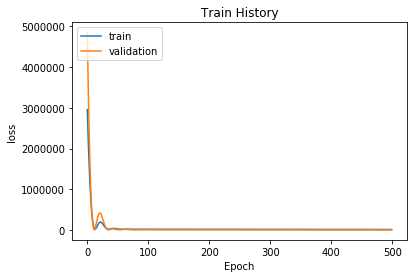

In [137]:
show_tarin_history(train_history,'loss','val_loss')

In [138]:
error=model.predict(XX_train).reshape([len(XX_train)])-np.array(YY_train)
np.average(error**2)**(1/2)

103.71116166283444

In [139]:
error=model.predict(XX_test).reshape([len(XX_test)])-np.array(YY_test)
np.average(error**2)**(1/2)

77.01940918127634

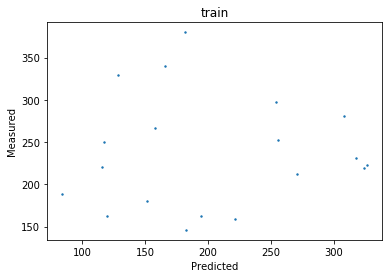

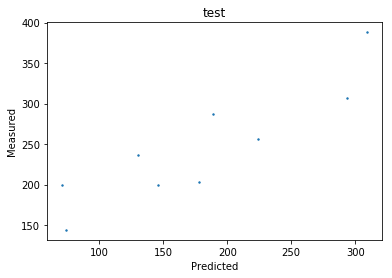

In [140]:
predict=model.predict(XX_train)
plotPaint(predict,YY_train,title="train")
predict=model.predict(XX_test)
plotPaint(predict,YY_test,title="test")

In [141]:
# predicted_sales = model.predict(newDataxxG)
# print("好店家預測")
# print(predicted_sales)
# predicted_sales = model.predict(newDataxxB)
# print("差店家預測")
# print(predicted_sales)
# predict=model.predict(newDataxxG)
# plotPaint(predict,YG,R=1)
# predict=model.predict(newDataxxB)
# plotPaint(predict,YB,R=1)

# 多層(DNN)

In [142]:
input_size=len(XX_train[0])#feature數量
batch_size=50#每批樣本大小
# epochs=5000#處理幾輪
epochs=1500#處理幾輪

model=Sequential()  #定義model
model.add(Dense(40,input_dim=input_size)) #加入層(緊密層) 產出個數40 輸入個數8 次元
model.add(Activation('relu')) #啟動函數
model.add(Dense(200)) 
model.add(Activation('relu')) 
model.add(Dense(200)) 
model.add(Dropout(0.3)) 
model.add(Activation('relu')) 
model.add(Dense(250)) 
model.add(Activation('relu')) 
for i in range(20):
    model.add(Dense(200-i*8)) 
    model.add(Activation('relu')) 
model.add(Dense(20)) 
# model.add(Dense(50)) 
model.add(Activation('relu'))
model.add(Dropout(0.2)) 

model.add(Dense(1))  
model.add(Activation('linear')) #啟動函數

In [143]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 40)                520       
_________________________________________________________________
activation_38 (Activation)   (None, 40)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 200)               8200      
_________________________________________________________________
activation_39 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
activation_40 (Activation)   (None, 200)               0         
__________

In [144]:
#loss成本函數mse(均方差)  optimizer最佳化工具adam(會自動調整學習速率、並繼承上一步的方法) metrics性能評估方法()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
# model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
# model.compile(loss="MSE",metrics=['accuracy'],optimizer='sgd')

In [145]:
#訓練開始 xx為feature Y為label  batch_size為每次放多少進去 epochs為處理幾輪 validation_split為抽多少樣本來驗證 verbose=1為每次顯示
train_history=model.fit(XX_train,YY_train,batch_size=batch_size,epochs=epochs,validation_split=0.2,verbose=1)
# train_history=model.fit(xx,Y,batch_size=batch_size,epochs=epochs,verbose=1)

Train on 15 samples, validate on 4 samples
Epoch 1/1500
15/15 [==============================] - 1s 82ms/step - loss: 60317.0117 - mean_absolute_error: 236.2211 - val_loss: 61700.4414 - val_mean_absolute_error: 242.8513
Epoch 2/1500
15/15 [==============================] - 0s 667us/step - loss: 59882.9648 - mean_absolute_error: 235.3095 - val_loss: 60792.3398 - val_mean_absolute_error: 241.0370
Epoch 3/1500
15/15 [==============================] - 0s 667us/step - loss: 59048.3555 - mean_absolute_error: 233.4759 - val_loss: 56496.6367 - val_mean_absolute_error: 232.2514
Epoch 4/1500
15/15 [==============================] - 0s 733us/step - loss: 56399.7461 - mean_absolute_error: 227.5668 - val_loss: 43329.8125 - val_mean_absolute_error: 202.8118
Epoch 5/1500
15/15 [==============================] - 0s 733us/step - loss: 49767.3828 - mean_absolute_error: 211.3482 - val_loss: 13451.8154 - val_mean_absolute_error: 106.3878
Epoch 6/1500
15/15 [==============================] - 0s 1ms/step - 

Epoch 47/1500
15/15 [==============================] - 0s 667us/step - loss: 26606.0977 - mean_absolute_error: 133.9859 - val_loss: 3909.8989 - val_mean_absolute_error: 55.4787
Epoch 48/1500
15/15 [==============================] - 0s 667us/step - loss: 19468.2402 - mean_absolute_error: 120.0328 - val_loss: 4894.3311 - val_mean_absolute_error: 62.9300
Epoch 49/1500
15/15 [==============================] - 0s 667us/step - loss: 26156.0547 - mean_absolute_error: 135.3006 - val_loss: 6700.2861 - val_mean_absolute_error: 69.4337
Epoch 50/1500
15/15 [==============================] - 0s 667us/step - loss: 27662.2930 - mean_absolute_error: 131.0423 - val_loss: 6833.7495 - val_mean_absolute_error: 69.8147
Epoch 51/1500
15/15 [==============================] - 0s 667us/step - loss: 22159.8457 - mean_absolute_error: 128.5930 - val_loss: 4380.5620 - val_mean_absolute_error: 60.0740
Epoch 52/1500
15/15 [==============================] - 0s 733us/step - loss: 20811.0039 - mean_absolute_error: 117.

Epoch 94/1500
15/15 [==============================] - 0s 1ms/step - loss: 27853.5957 - mean_absolute_error: 144.6525 - val_loss: 6545.6978 - val_mean_absolute_error: 68.8482
Epoch 95/1500
15/15 [==============================] - 0s 600us/step - loss: 25071.1426 - mean_absolute_error: 135.7484 - val_loss: 9034.9775 - val_mean_absolute_error: 81.6520
Epoch 96/1500
15/15 [==============================] - 0s 733us/step - loss: 25161.0020 - mean_absolute_error: 133.9028 - val_loss: 9061.0244 - val_mean_absolute_error: 81.8252
Epoch 97/1500
15/15 [==============================] - 0s 733us/step - loss: 28798.2773 - mean_absolute_error: 139.2859 - val_loss: 6509.5513 - val_mean_absolute_error: 68.7330
Epoch 98/1500
15/15 [==============================] - 0s 733us/step - loss: 23911.8047 - mean_absolute_error: 136.2853 - val_loss: 3824.0386 - val_mean_absolute_error: 53.8416
Epoch 99/1500
15/15 [==============================] - 0s 600us/step - loss: 19574.5957 - mean_absolute_error: 117.17

Epoch 140/1500
15/15 [==============================] - 0s 667us/step - loss: 26917.8301 - mean_absolute_error: 135.9180 - val_loss: 5043.3516 - val_mean_absolute_error: 63.4328
Epoch 141/1500
15/15 [==============================] - 0s 667us/step - loss: 24525.4102 - mean_absolute_error: 141.7006 - val_loss: 3894.0476 - val_mean_absolute_error: 50.6644
Epoch 142/1500
15/15 [==============================] - 0s 667us/step - loss: 23342.0586 - mean_absolute_error: 131.6361 - val_loss: 5592.5820 - val_mean_absolute_error: 58.8540
Epoch 143/1500
15/15 [==============================] - 0s 667us/step - loss: 24061.8691 - mean_absolute_error: 134.0768 - val_loss: 7509.7168 - val_mean_absolute_error: 63.5700
Epoch 144/1500
15/15 [==============================] - 0s 733us/step - loss: 21476.9668 - mean_absolute_error: 124.9253 - val_loss: 9016.4951 - val_mean_absolute_error: 68.5423
Epoch 145/1500
15/15 [==============================] - 0s 733us/step - loss: 33990.9141 - mean_absolute_error

Epoch 186/1500
15/15 [==============================] - 0s 667us/step - loss: 26171.5293 - mean_absolute_error: 132.7589 - val_loss: 26205.2480 - val_mean_absolute_error: 131.3186
Epoch 187/1500
15/15 [==============================] - 0s 733us/step - loss: 28365.8047 - mean_absolute_error: 134.4930 - val_loss: 10483.2520 - val_mean_absolute_error: 73.6162
Epoch 188/1500
15/15 [==============================] - 0s 667us/step - loss: 23733.6934 - mean_absolute_error: 128.5076 - val_loss: 3832.2568 - val_mean_absolute_error: 49.9771
Epoch 189/1500
15/15 [==============================] - 0s 667us/step - loss: 17687.9629 - mean_absolute_error: 109.6311 - val_loss: 4748.0381 - val_mean_absolute_error: 61.9460
Epoch 190/1500
15/15 [==============================] - 0s 667us/step - loss: 22508.9316 - mean_absolute_error: 122.9832 - val_loss: 6715.5596 - val_mean_absolute_error: 69.0777
Epoch 191/1500
15/15 [==============================] - 0s 667us/step - loss: 25674.2305 - mean_absolute_er

Epoch 232/1500
15/15 [==============================] - 0s 600us/step - loss: 23689.9668 - mean_absolute_error: 136.0222 - val_loss: 6670.4785 - val_mean_absolute_error: 61.2703
Epoch 233/1500
15/15 [==============================] - 0s 600us/step - loss: 19689.6289 - mean_absolute_error: 121.8836 - val_loss: 6831.3813 - val_mean_absolute_error: 61.6350
Epoch 234/1500
15/15 [==============================] - 0s 667us/step - loss: 21807.4434 - mean_absolute_error: 130.1957 - val_loss: 4936.0376 - val_mean_absolute_error: 56.3152
Epoch 235/1500
15/15 [==============================] - 0s 733us/step - loss: 22896.7520 - mean_absolute_error: 129.4391 - val_loss: 3837.9338 - val_mean_absolute_error: 50.1617
Epoch 236/1500
15/15 [==============================] - 0s 667us/step - loss: 26015.2148 - mean_absolute_error: 137.6842 - val_loss: 4147.1802 - val_mean_absolute_error: 58.2792
Epoch 237/1500
15/15 [==============================] - 0s 733us/step - loss: 22064.5664 - mean_absolute_error

15/15 [==============================] - 0s 667us/step - loss: 20888.6211 - mean_absolute_error: 124.2453 - val_loss: 3691.8677 - val_mean_absolute_error: 51.0391
Epoch 279/1500
15/15 [==============================] - 0s 600us/step - loss: 22214.8438 - mean_absolute_error: 124.8390 - val_loss: 3956.3286 - val_mean_absolute_error: 51.2871
Epoch 280/1500
15/15 [==============================] - 0s 667us/step - loss: 23354.5820 - mean_absolute_error: 131.3391 - val_loss: 4734.2559 - val_mean_absolute_error: 55.3173
Epoch 281/1500
15/15 [==============================] - 0s 733us/step - loss: 21092.3867 - mean_absolute_error: 132.6265 - val_loss: 5338.9907 - val_mean_absolute_error: 57.4044
Epoch 282/1500
15/15 [==============================] - 0s 667us/step - loss: 22924.7676 - mean_absolute_error: 134.7674 - val_loss: 5709.1367 - val_mean_absolute_error: 58.4889
Epoch 283/1500
15/15 [==============================] - 0s 667us/step - loss: 22533.7383 - mean_absolute_error: 125.6101 - va

Epoch 325/1500
15/15 [==============================] - 0s 667us/step - loss: 23041.6621 - mean_absolute_error: 123.2942 - val_loss: 4057.6782 - val_mean_absolute_error: 57.5153
Epoch 326/1500
15/15 [==============================] - 0s 667us/step - loss: 21487.0078 - mean_absolute_error: 118.9044 - val_loss: 3703.0552 - val_mean_absolute_error: 48.7142
Epoch 327/1500
15/15 [==============================] - 0s 667us/step - loss: 24011.4121 - mean_absolute_error: 132.0487 - val_loss: 3996.0107 - val_mean_absolute_error: 51.4709
Epoch 328/1500
15/15 [==============================] - 0s 667us/step - loss: 24176.5996 - mean_absolute_error: 136.6349 - val_loss: 4201.4292 - val_mean_absolute_error: 52.6802
Epoch 329/1500
15/15 [==============================] - 0s 600us/step - loss: 22503.2559 - mean_absolute_error: 128.5439 - val_loss: 4694.2866 - val_mean_absolute_error: 54.8812
Epoch 330/1500
15/15 [==============================] - 0s 667us/step - loss: 21433.3262 - mean_absolute_error

15/15 [==============================] - 0s 733us/step - loss: 25990.5820 - mean_absolute_error: 133.6044 - val_loss: 3594.6846 - val_mean_absolute_error: 49.0629
Epoch 372/1500
15/15 [==============================] - 0s 667us/step - loss: 22574.3516 - mean_absolute_error: 129.9392 - val_loss: 3642.0862 - val_mean_absolute_error: 48.2102
Epoch 373/1500
15/15 [==============================] - 0s 733us/step - loss: 21225.4727 - mean_absolute_error: 121.5718 - val_loss: 3806.5513 - val_mean_absolute_error: 49.9439
Epoch 374/1500
15/15 [==============================] - 0s 733us/step - loss: 18935.3730 - mean_absolute_error: 116.1933 - val_loss: 4294.1963 - val_mean_absolute_error: 52.8122
Epoch 375/1500
15/15 [==============================] - 0s 667us/step - loss: 21756.3223 - mean_absolute_error: 127.8293 - val_loss: 4762.1694 - val_mean_absolute_error: 54.6986
Epoch 376/1500
15/15 [==============================] - 0s 733us/step - loss: 21716.4863 - mean_absolute_error: 127.8900 - va

Epoch 418/1500
15/15 [==============================] - 0s 667us/step - loss: 26544.2051 - mean_absolute_error: 142.7671 - val_loss: 5072.3135 - val_mean_absolute_error: 62.3190
Epoch 419/1500
15/15 [==============================] - 0s 667us/step - loss: 22837.5625 - mean_absolute_error: 122.5919 - val_loss: 4900.3530 - val_mean_absolute_error: 61.5474
Epoch 420/1500
15/15 [==============================] - 0s 667us/step - loss: 22396.1777 - mean_absolute_error: 131.5528 - val_loss: 4131.1289 - val_mean_absolute_error: 57.6673
Epoch 421/1500
15/15 [==============================] - 0s 733us/step - loss: 21547.8965 - mean_absolute_error: 116.3493 - val_loss: 3493.2576 - val_mean_absolute_error: 47.4004
Epoch 422/1500
15/15 [==============================] - 0s 667us/step - loss: 19258.2715 - mean_absolute_error: 119.9294 - val_loss: 7437.0137 - val_mean_absolute_error: 63.9814
Epoch 423/1500
15/15 [==============================] - 0s 733us/step - loss: 27924.7383 - mean_absolute_error

Epoch 464/1500
15/15 [==============================] - 0s 733us/step - loss: 24075.5605 - mean_absolute_error: 132.1352 - val_loss: 3539.0325 - val_mean_absolute_error: 47.4364
Epoch 465/1500
15/15 [==============================] - 0s 733us/step - loss: 19930.8340 - mean_absolute_error: 118.7176 - val_loss: 5547.2632 - val_mean_absolute_error: 55.5943
Epoch 466/1500
15/15 [==============================] - 0s 667us/step - loss: 24524.1680 - mean_absolute_error: 128.2980 - val_loss: 7070.4966 - val_mean_absolute_error: 62.9665
Epoch 467/1500
15/15 [==============================] - 0s 667us/step - loss: 27421.2383 - mean_absolute_error: 143.4655 - val_loss: 4731.8916 - val_mean_absolute_error: 53.0742
Epoch 468/1500
15/15 [==============================] - 0s 667us/step - loss: 22559.9961 - mean_absolute_error: 128.4317 - val_loss: 3436.0332 - val_mean_absolute_error: 46.3802
Epoch 469/1500
15/15 [==============================] - 0s 733us/step - loss: 20724.5957 - mean_absolute_error

15/15 [==============================] - 0s 667us/step - loss: 26196.9160 - mean_absolute_error: 135.1308 - val_loss: 3150.7222 - val_mean_absolute_error: 48.4840
Epoch 511/1500
15/15 [==============================] - 0s 667us/step - loss: 19329.9434 - mean_absolute_error: 111.1369 - val_loss: 3728.5581 - val_mean_absolute_error: 47.2069
Epoch 512/1500
15/15 [==============================] - 0s 733us/step - loss: 17076.5762 - mean_absolute_error: 104.2011 - val_loss: 9764.6123 - val_mean_absolute_error: 74.0720
Epoch 513/1500
15/15 [==============================] - 0s 600us/step - loss: 18156.6543 - mean_absolute_error: 114.5998 - val_loss: 16101.2627 - val_mean_absolute_error: 101.4417
Epoch 514/1500
15/15 [==============================] - 0s 667us/step - loss: 14100.8232 - mean_absolute_error: 97.7579 - val_loss: 22173.1309 - val_mean_absolute_error: 124.6951
Epoch 515/1500
15/15 [==============================] - 0s 733us/step - loss: 21175.9824 - mean_absolute_error: 125.3617 -

Epoch 556/1500
15/15 [==============================] - 0s 733us/step - loss: 16624.0449 - mean_absolute_error: 112.0297 - val_loss: 2388.2498 - val_mean_absolute_error: 39.4078
Epoch 557/1500
15/15 [==============================] - 0s 667us/step - loss: 15456.0332 - mean_absolute_error: 101.4879 - val_loss: 2335.8281 - val_mean_absolute_error: 39.2123
Epoch 558/1500
15/15 [==============================] - 0s 667us/step - loss: 14394.1270 - mean_absolute_error: 100.1671 - val_loss: 2169.7549 - val_mean_absolute_error: 35.9389
Epoch 559/1500
15/15 [==============================] - 0s 667us/step - loss: 11889.5439 - mean_absolute_error: 93.5360 - val_loss: 2654.4524 - val_mean_absolute_error: 44.4184
Epoch 560/1500
15/15 [==============================] - 0s 733us/step - loss: 15062.5000 - mean_absolute_error: 107.8115 - val_loss: 2364.7444 - val_mean_absolute_error: 38.0480
Epoch 561/1500
15/15 [==============================] - 0s 667us/step - loss: 16747.2773 - mean_absolute_error:

Epoch 603/1500
15/15 [==============================] - 0s 733us/step - loss: 20314.8848 - mean_absolute_error: 130.3825 - val_loss: 15079.3594 - val_mean_absolute_error: 103.7068
Epoch 604/1500
15/15 [==============================] - 0s 733us/step - loss: 9845.5303 - mean_absolute_error: 85.0435 - val_loss: 3950.5972 - val_mean_absolute_error: 51.4728
Epoch 605/1500
15/15 [==============================] - 0s 600us/step - loss: 8343.0840 - mean_absolute_error: 72.5735 - val_loss: 15702.5547 - val_mean_absolute_error: 112.3903
Epoch 606/1500
15/15 [==============================] - 0s 667us/step - loss: 25621.4609 - mean_absolute_error: 133.5505 - val_loss: 6196.1494 - val_mean_absolute_error: 72.6679
Epoch 607/1500
15/15 [==============================] - 0s 667us/step - loss: 7820.3813 - mean_absolute_error: 61.3978 - val_loss: 16398.2500 - val_mean_absolute_error: 113.1147
Epoch 608/1500
15/15 [==============================] - 0s 733us/step - loss: 19715.8691 - mean_absolute_error

Epoch 650/1500
15/15 [==============================] - 0s 667us/step - loss: 4886.8750 - mean_absolute_error: 56.5362 - val_loss: 7930.1558 - val_mean_absolute_error: 67.9201
Epoch 651/1500
15/15 [==============================] - 0s 733us/step - loss: 11944.7510 - mean_absolute_error: 87.2169 - val_loss: 6514.4365 - val_mean_absolute_error: 79.8122
Epoch 652/1500
15/15 [==============================] - 0s 733us/step - loss: 8635.2188 - mean_absolute_error: 80.2319 - val_loss: 12288.9580 - val_mean_absolute_error: 102.0811
Epoch 653/1500
15/15 [==============================] - 0s 600us/step - loss: 9414.7412 - mean_absolute_error: 80.9081 - val_loss: 12207.6465 - val_mean_absolute_error: 101.4950
Epoch 654/1500
15/15 [==============================] - 0s 667us/step - loss: 11024.8994 - mean_absolute_error: 85.2269 - val_loss: 6396.2812 - val_mean_absolute_error: 78.6446
Epoch 655/1500
15/15 [==============================] - 0s 667us/step - loss: 6078.5103 - mean_absolute_error: 65.

Epoch 697/1500
15/15 [==============================] - 0s 600us/step - loss: 5089.9917 - mean_absolute_error: 56.7767 - val_loss: 6578.8853 - val_mean_absolute_error: 79.4152
Epoch 698/1500
15/15 [==============================] - 0s 667us/step - loss: 9347.4873 - mean_absolute_error: 77.9520 - val_loss: 5217.3379 - val_mean_absolute_error: 70.5973
Epoch 699/1500
15/15 [==============================] - 0s 667us/step - loss: 5242.7681 - mean_absolute_error: 57.4638 - val_loss: 4037.0305 - val_mean_absolute_error: 55.1605
Epoch 700/1500
15/15 [==============================] - 0s 733us/step - loss: 6738.5591 - mean_absolute_error: 66.6741 - val_loss: 4073.0566 - val_mean_absolute_error: 55.7017
Epoch 701/1500
15/15 [==============================] - 0s 733us/step - loss: 7038.1572 - mean_absolute_error: 59.0600 - val_loss: 3956.9128 - val_mean_absolute_error: 49.7641
Epoch 702/1500
15/15 [==============================] - 0s 667us/step - loss: 7510.8530 - mean_absolute_error: 72.0676 -

Epoch 744/1500
15/15 [==============================] - 0s 733us/step - loss: 5754.2178 - mean_absolute_error: 53.8281 - val_loss: 5950.6641 - val_mean_absolute_error: 73.4169
Epoch 745/1500
15/15 [==============================] - 0s 800us/step - loss: 6093.8472 - mean_absolute_error: 61.2793 - val_loss: 6018.2690 - val_mean_absolute_error: 51.7192
Epoch 746/1500
15/15 [==============================] - 0s 667us/step - loss: 9982.4287 - mean_absolute_error: 78.1711 - val_loss: 6097.5317 - val_mean_absolute_error: 71.2829
Epoch 747/1500
15/15 [==============================] - 0s 667us/step - loss: 6039.3853 - mean_absolute_error: 56.0536 - val_loss: 7340.6440 - val_mean_absolute_error: 84.8107
Epoch 748/1500
15/15 [==============================] - 0s 667us/step - loss: 5688.2651 - mean_absolute_error: 59.4195 - val_loss: 7432.9487 - val_mean_absolute_error: 85.6009
Epoch 749/1500
15/15 [==============================] - 0s 733us/step - loss: 7443.1450 - mean_absolute_error: 64.8402 -

Epoch 791/1500
15/15 [==============================] - 0s 667us/step - loss: 10590.1846 - mean_absolute_error: 89.0492 - val_loss: 5861.8096 - val_mean_absolute_error: 73.0324
Epoch 792/1500
15/15 [==============================] - 0s 667us/step - loss: 5657.0308 - mean_absolute_error: 53.1285 - val_loss: 6409.5093 - val_mean_absolute_error: 46.2701
Epoch 793/1500
15/15 [==============================] - 0s 667us/step - loss: 8179.5991 - mean_absolute_error: 78.1143 - val_loss: 5236.6382 - val_mean_absolute_error: 53.7357
Epoch 794/1500
15/15 [==============================] - 0s 800us/step - loss: 4906.6421 - mean_absolute_error: 55.9653 - val_loss: 6150.4785 - val_mean_absolute_error: 74.5177
Epoch 795/1500
15/15 [==============================] - 0s 667us/step - loss: 6852.1221 - mean_absolute_error: 61.9719 - val_loss: 8274.7773 - val_mean_absolute_error: 86.1207
Epoch 796/1500
15/15 [==============================] - 0s 667us/step - loss: 6638.3389 - mean_absolute_error: 62.2809 

Epoch 838/1500
15/15 [==============================] - 0s 667us/step - loss: 5421.9795 - mean_absolute_error: 63.1716 - val_loss: 5791.4434 - val_mean_absolute_error: 42.5114
Epoch 839/1500
15/15 [==============================] - 0s 733us/step - loss: 3808.2109 - mean_absolute_error: 46.8605 - val_loss: 12968.2891 - val_mean_absolute_error: 97.1981
Epoch 840/1500
15/15 [==============================] - 0s 667us/step - loss: 22869.8418 - mean_absolute_error: 118.5968 - val_loss: 9676.9727 - val_mean_absolute_error: 94.6633
Epoch 841/1500
15/15 [==============================] - 0s 667us/step - loss: 9360.7910 - mean_absolute_error: 77.7754 - val_loss: 20019.6094 - val_mean_absolute_error: 123.9353
Epoch 842/1500
15/15 [==============================] - 0s 667us/step - loss: 19060.2578 - mean_absolute_error: 125.0799 - val_loss: 22723.5703 - val_mean_absolute_error: 136.8261
Epoch 843/1500
15/15 [==============================] - 0s 733us/step - loss: 21893.4180 - mean_absolute_error:

Epoch 885/1500
15/15 [==============================] - 0s 667us/step - loss: 7279.2241 - mean_absolute_error: 70.1833 - val_loss: 7062.6465 - val_mean_absolute_error: 82.2410
Epoch 886/1500
15/15 [==============================] - 0s 733us/step - loss: 4655.5488 - mean_absolute_error: 52.5229 - val_loss: 6313.9810 - val_mean_absolute_error: 77.5179
Epoch 887/1500
15/15 [==============================] - 0s 667us/step - loss: 3769.7615 - mean_absolute_error: 46.2008 - val_loss: 5526.9863 - val_mean_absolute_error: 70.8127
Epoch 888/1500
15/15 [==============================] - 0s 667us/step - loss: 4564.2837 - mean_absolute_error: 56.3062 - val_loss: 4933.1001 - val_mean_absolute_error: 60.3502
Epoch 889/1500
15/15 [==============================] - 0s 667us/step - loss: 4170.7373 - mean_absolute_error: 51.0059 - val_loss: 4983.3125 - val_mean_absolute_error: 54.2317
Epoch 890/1500
15/15 [==============================] - 0s 733us/step - loss: 5535.5703 - mean_absolute_error: 61.3765 -

Epoch 932/1500
15/15 [==============================] - 0s 667us/step - loss: 7433.7310 - mean_absolute_error: 70.4830 - val_loss: 4376.8667 - val_mean_absolute_error: 44.8606
Epoch 933/1500
15/15 [==============================] - 0s 733us/step - loss: 7923.1875 - mean_absolute_error: 73.5894 - val_loss: 4050.9092 - val_mean_absolute_error: 54.9309
Epoch 934/1500
15/15 [==============================] - 0s 733us/step - loss: 10058.3623 - mean_absolute_error: 78.2899 - val_loss: 6214.8164 - val_mean_absolute_error: 77.7994
Epoch 935/1500
15/15 [==============================] - 0s 667us/step - loss: 6038.9473 - mean_absolute_error: 57.5382 - val_loss: 7356.1094 - val_mean_absolute_error: 83.8019
Epoch 936/1500
15/15 [==============================] - 0s 667us/step - loss: 7938.4756 - mean_absolute_error: 76.6368 - val_loss: 6217.5957 - val_mean_absolute_error: 77.8638
Epoch 937/1500
15/15 [==============================] - 0s 667us/step - loss: 4133.6182 - mean_absolute_error: 46.7687 

Epoch 979/1500
15/15 [==============================] - 0s 800us/step - loss: 11250.9033 - mean_absolute_error: 80.3399 - val_loss: 5805.3496 - val_mean_absolute_error: 57.5640
Epoch 980/1500
15/15 [==============================] - 0s 667us/step - loss: 6372.7676 - mean_absolute_error: 62.5522 - val_loss: 6826.2563 - val_mean_absolute_error: 54.3347
Epoch 981/1500
15/15 [==============================] - 0s 667us/step - loss: 7127.2563 - mean_absolute_error: 63.0835 - val_loss: 5801.9316 - val_mean_absolute_error: 54.5967
Epoch 982/1500
15/15 [==============================] - 0s 600us/step - loss: 9028.2432 - mean_absolute_error: 79.3965 - val_loss: 6363.0742 - val_mean_absolute_error: 75.6942
Epoch 983/1500
15/15 [==============================] - 0s 733us/step - loss: 7357.9053 - mean_absolute_error: 65.9705 - val_loss: 9468.0566 - val_mean_absolute_error: 89.6836
Epoch 984/1500
15/15 [==============================] - 0s 733us/step - loss: 9467.8887 - mean_absolute_error: 81.2092 

Epoch 1026/1500
15/15 [==============================] - 0s 733us/step - loss: 5935.1592 - mean_absolute_error: 62.3464 - val_loss: 6157.9287 - val_mean_absolute_error: 76.5888
Epoch 1027/1500
15/15 [==============================] - 0s 667us/step - loss: 5336.6851 - mean_absolute_error: 60.9914 - val_loss: 6462.4658 - val_mean_absolute_error: 78.2273
Epoch 1028/1500
15/15 [==============================] - 0s 667us/step - loss: 4137.8662 - mean_absolute_error: 51.8326 - val_loss: 6016.2207 - val_mean_absolute_error: 70.9100
Epoch 1029/1500
15/15 [==============================] - 0s 667us/step - loss: 5840.4688 - mean_absolute_error: 55.4739 - val_loss: 6573.3682 - val_mean_absolute_error: 73.9851
Epoch 1030/1500
15/15 [==============================] - 0s 667us/step - loss: 8116.8369 - mean_absolute_error: 71.9121 - val_loss: 7900.7803 - val_mean_absolute_error: 86.2923
Epoch 1031/1500
15/15 [==============================] - 0s 667us/step - loss: 7696.9473 - mean_absolute_error: 74.

Epoch 1073/1500
15/15 [==============================] - 0s 600us/step - loss: 5501.2065 - mean_absolute_error: 59.6708 - val_loss: 11107.2168 - val_mean_absolute_error: 99.9140
Epoch 1074/1500
15/15 [==============================] - 0s 667us/step - loss: 9137.2412 - mean_absolute_error: 76.5851 - val_loss: 12406.8320 - val_mean_absolute_error: 103.5213
Epoch 1075/1500
15/15 [==============================] - 0s 800us/step - loss: 7468.7534 - mean_absolute_error: 72.4222 - val_loss: 11847.0508 - val_mean_absolute_error: 101.9015
Epoch 1076/1500
15/15 [==============================] - 0s 667us/step - loss: 9565.6875 - mean_absolute_error: 81.3733 - val_loss: 9499.6025 - val_mean_absolute_error: 93.9561
Epoch 1077/1500
15/15 [==============================] - 0s 667us/step - loss: 6963.1919 - mean_absolute_error: 62.3375 - val_loss: 6428.6626 - val_mean_absolute_error: 73.7416
Epoch 1078/1500
15/15 [==============================] - 0s 667us/step - loss: 3406.8115 - mean_absolute_error

Epoch 1120/1500
15/15 [==============================] - 0s 667us/step - loss: 7150.4175 - mean_absolute_error: 70.1288 - val_loss: 7151.0918 - val_mean_absolute_error: 77.6033
Epoch 1121/1500
15/15 [==============================] - 0s 733us/step - loss: 9068.7480 - mean_absolute_error: 71.4138 - val_loss: 7071.7539 - val_mean_absolute_error: 76.5632
Epoch 1122/1500
15/15 [==============================] - 0s 800us/step - loss: 6397.1675 - mean_absolute_error: 73.5784 - val_loss: 7538.3926 - val_mean_absolute_error: 83.3220
Epoch 1123/1500
15/15 [==============================] - 0s 800us/step - loss: 10712.0059 - mean_absolute_error: 81.8574 - val_loss: 10109.2168 - val_mean_absolute_error: 98.0132
Epoch 1124/1500
15/15 [==============================] - 0s 667us/step - loss: 6301.2925 - mean_absolute_error: 62.6420 - val_loss: 11167.5312 - val_mean_absolute_error: 102.0103
Epoch 1125/1500
15/15 [==============================] - 0s 800us/step - loss: 8608.6279 - mean_absolute_error:

Epoch 1167/1500
15/15 [==============================] - 0s 667us/step - loss: 5617.0439 - mean_absolute_error: 56.5535 - val_loss: 7240.0352 - val_mean_absolute_error: 79.5750
Epoch 1168/1500
15/15 [==============================] - 0s 667us/step - loss: 7640.9644 - mean_absolute_error: 75.1314 - val_loss: 8537.0723 - val_mean_absolute_error: 90.9282
Epoch 1169/1500
15/15 [==============================] - 0s 667us/step - loss: 8630.8799 - mean_absolute_error: 68.8932 - val_loss: 10439.6426 - val_mean_absolute_error: 100.1863
Epoch 1170/1500
15/15 [==============================] - 0s 600us/step - loss: 4349.2354 - mean_absolute_error: 54.6198 - val_loss: 10803.3779 - val_mean_absolute_error: 101.1832
Epoch 1171/1500
15/15 [==============================] - 0s 733us/step - loss: 9503.2090 - mean_absolute_error: 78.9627 - val_loss: 9618.9033 - val_mean_absolute_error: 96.0844
Epoch 1172/1500
15/15 [==============================] - 0s 667us/step - loss: 4699.1963 - mean_absolute_error:

15/15 [==============================] - 0s 667us/step - loss: 7905.7803 - mean_absolute_error: 71.0198 - val_loss: 6575.2295 - val_mean_absolute_error: 68.2826
Epoch 1214/1500
15/15 [==============================] - 0s 667us/step - loss: 9576.8916 - mean_absolute_error: 67.2025 - val_loss: 6553.1367 - val_mean_absolute_error: 68.0806
Epoch 1215/1500
15/15 [==============================] - 0s 667us/step - loss: 7754.7456 - mean_absolute_error: 75.7591 - val_loss: 8177.4814 - val_mean_absolute_error: 87.5904
Epoch 1216/1500
15/15 [==============================] - 0s 667us/step - loss: 6176.0815 - mean_absolute_error: 62.6898 - val_loss: 9642.3965 - val_mean_absolute_error: 96.8211
Epoch 1217/1500
15/15 [==============================] - 0s 600us/step - loss: 8160.7544 - mean_absolute_error: 70.6993 - val_loss: 8801.7920 - val_mean_absolute_error: 93.0240
Epoch 1218/1500
15/15 [==============================] - 0s 733us/step - loss: 12713.2041 - mean_absolute_error: 91.8455 - val_loss

Epoch 1260/1500
15/15 [==============================] - 0s 733us/step - loss: 5609.3145 - mean_absolute_error: 57.3693 - val_loss: 6128.8071 - val_mean_absolute_error: 74.9342
Epoch 1261/1500
15/15 [==============================] - 0s 667us/step - loss: 5619.0332 - mean_absolute_error: 57.8042 - val_loss: 8236.0195 - val_mean_absolute_error: 90.6384
Epoch 1262/1500
15/15 [==============================] - 0s 667us/step - loss: 5994.1543 - mean_absolute_error: 62.3240 - val_loss: 11195.4668 - val_mean_absolute_error: 103.5271
Epoch 1263/1500
15/15 [==============================] - 0s 733us/step - loss: 5699.8003 - mean_absolute_error: 60.5365 - val_loss: 10893.2383 - val_mean_absolute_error: 102.7914
Epoch 1264/1500
15/15 [==============================] - 0s 733us/step - loss: 6988.4170 - mean_absolute_error: 66.3213 - val_loss: 8409.9688 - val_mean_absolute_error: 91.4028
Epoch 1265/1500
15/15 [==============================] - 0s 667us/step - loss: 9488.9346 - mean_absolute_error:

Epoch 1307/1500
15/15 [==============================] - 0s 733us/step - loss: 13452.7080 - mean_absolute_error: 100.2843 - val_loss: 8626.0469 - val_mean_absolute_error: 89.1845
Epoch 1308/1500
15/15 [==============================] - 0s 733us/step - loss: 8959.5195 - mean_absolute_error: 73.9300 - val_loss: 5165.9365 - val_mean_absolute_error: 55.9357
Epoch 1309/1500
15/15 [==============================] - 0s 867us/step - loss: 6726.2158 - mean_absolute_error: 70.3185 - val_loss: 8749.2432 - val_mean_absolute_error: 62.8337
Epoch 1310/1500
15/15 [==============================] - 0s 667us/step - loss: 11971.0000 - mean_absolute_error: 86.2445 - val_loss: 5882.3472 - val_mean_absolute_error: 52.1064
Epoch 1311/1500
15/15 [==============================] - 0s 667us/step - loss: 7103.8716 - mean_absolute_error: 64.6581 - val_loss: 7939.0557 - val_mean_absolute_error: 87.2394
Epoch 1312/1500
15/15 [==============================] - 0s 667us/step - loss: 8580.4189 - mean_absolute_error: 

Epoch 1354/1500
15/15 [==============================] - 0s 667us/step - loss: 7229.5947 - mean_absolute_error: 67.5796 - val_loss: 11924.1992 - val_mean_absolute_error: 104.0913
Epoch 1355/1500
15/15 [==============================] - 0s 733us/step - loss: 8938.3301 - mean_absolute_error: 67.4490 - val_loss: 10904.1953 - val_mean_absolute_error: 100.7121
Epoch 1356/1500
15/15 [==============================] - 0s 667us/step - loss: 7291.6396 - mean_absolute_error: 65.2366 - val_loss: 8756.5020 - val_mean_absolute_error: 92.1019
Epoch 1357/1500
15/15 [==============================] - 0s 667us/step - loss: 5900.1226 - mean_absolute_error: 64.4417 - val_loss: 6861.6333 - val_mean_absolute_error: 80.7100
Epoch 1358/1500
15/15 [==============================] - 0s 733us/step - loss: 5049.0498 - mean_absolute_error: 54.3359 - val_loss: 5881.1709 - val_mean_absolute_error: 66.8474
Epoch 1359/1500
15/15 [==============================] - 0s 733us/step - loss: 6520.6685 - mean_absolute_error:

Epoch 1401/1500
15/15 [==============================] - 0s 667us/step - loss: 4487.9004 - mean_absolute_error: 51.2052 - val_loss: 4467.7041 - val_mean_absolute_error: 59.4492
Epoch 1402/1500
15/15 [==============================] - 0s 600us/step - loss: 8555.7002 - mean_absolute_error: 69.6491 - val_loss: 4285.3442 - val_mean_absolute_error: 51.2268
Epoch 1403/1500
15/15 [==============================] - 0s 667us/step - loss: 7206.8027 - mean_absolute_error: 62.8937 - val_loss: 4281.1860 - val_mean_absolute_error: 60.9757
Epoch 1404/1500
15/15 [==============================] - 0s 667us/step - loss: 9437.1133 - mean_absolute_error: 78.8844 - val_loss: 5279.5439 - val_mean_absolute_error: 71.7592
Epoch 1405/1500
15/15 [==============================] - 0s 667us/step - loss: 4886.6909 - mean_absolute_error: 53.3091 - val_loss: 5635.9834 - val_mean_absolute_error: 74.2000
Epoch 1406/1500
15/15 [==============================] - 0s 600us/step - loss: 9093.0312 - mean_absolute_error: 81.

Epoch 1448/1500
15/15 [==============================] - 0s 667us/step - loss: 4186.8154 - mean_absolute_error: 55.1942 - val_loss: 5255.1846 - val_mean_absolute_error: 56.4199
Epoch 1449/1500
15/15 [==============================] - 0s 667us/step - loss: 10247.2676 - mean_absolute_error: 79.8758 - val_loss: 5249.0781 - val_mean_absolute_error: 64.8743
Epoch 1450/1500
15/15 [==============================] - 0s 733us/step - loss: 8031.1509 - mean_absolute_error: 76.2140 - val_loss: 7130.7705 - val_mean_absolute_error: 82.3581
Epoch 1451/1500
15/15 [==============================] - 0s 733us/step - loss: 4246.3120 - mean_absolute_error: 51.1362 - val_loss: 8816.1504 - val_mean_absolute_error: 90.3314
Epoch 1452/1500
15/15 [==============================] - 0s 667us/step - loss: 6694.8193 - mean_absolute_error: 67.7761 - val_loss: 8311.3486 - val_mean_absolute_error: 88.3572
Epoch 1453/1500
15/15 [==============================] - 0s 667us/step - loss: 6166.2920 - mean_absolute_error: 64

Epoch 1495/1500
15/15 [==============================] - 0s 733us/step - loss: 4541.9697 - mean_absolute_error: 54.9374 - val_loss: 8026.3892 - val_mean_absolute_error: 88.3606
Epoch 1496/1500
15/15 [==============================] - 0s 667us/step - loss: 6709.5796 - mean_absolute_error: 64.4946 - val_loss: 7246.2393 - val_mean_absolute_error: 84.1212
Epoch 1497/1500
15/15 [==============================] - 0s 733us/step - loss: 5414.4526 - mean_absolute_error: 55.9094 - val_loss: 6250.8418 - val_mean_absolute_error: 76.8207
Epoch 1498/1500
15/15 [==============================] - 0s 667us/step - loss: 5999.3296 - mean_absolute_error: 56.9147 - val_loss: 5587.9980 - val_mean_absolute_error: 64.9878
Epoch 1499/1500
15/15 [==============================] - 0s 733us/step - loss: 7099.5464 - mean_absolute_error: 64.9600 - val_loss: 5463.2734 - val_mean_absolute_error: 58.8906
Epoch 1500/1500
15/15 [==============================] - 0s 733us/step - loss: 5986.3848 - mean_absolute_error: 64.

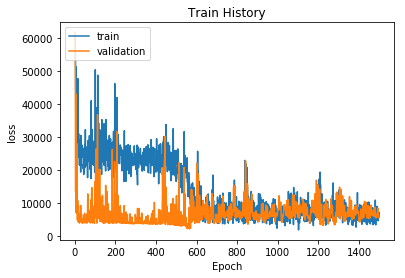

In [146]:
#劃出準確度歷程
import matplotlib.pyplot as plt
def show_tarin_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel("Epoch")
    plt.legend(['train','validation'],loc="upper left")
    plt.show()
show_tarin_history(train_history,'loss','val_loss')
# show_tarin_history(train_history,'loss','loss')

In [147]:
error=model.predict(XX_train).reshape([len(XX_train)])-np.array(YY_train)
np.average(error**2)**(1/2)

63.155756607635176

In [148]:
error=model.predict(XX_test).reshape([len(XX_test)])-np.array(YY_test)
np.average(error**2)**(1/2)

85.34365033382343

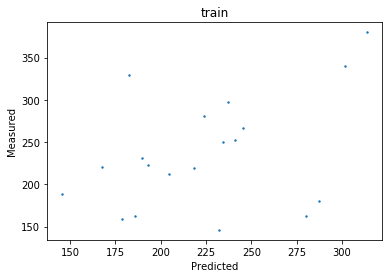

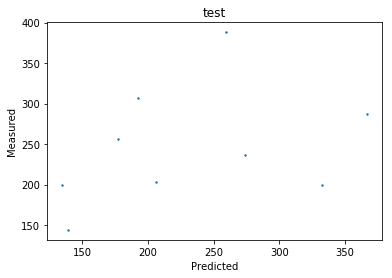

In [149]:
predict=model.predict(XX_train)
plotPaint(predict,YY_train,title="train")
predict=model.predict(XX_test)
plotPaint(predict,YY_test,title="test")

In [150]:
# predict=model.predict(newDataxxG)
# plotPaint(predict,YG,R=1)
# predict=model.predict(newDataxxB)
# plotPaint(predict,YB,R=1)

In [151]:
# predicted_sales = model.predict(newDataxxG)
# predicted_sales

In [152]:
# predicted_sales = model.predict(newDataxxB)
# predicted_sales

# ====================預測類型===================

# 試跑SKLEARN

In [158]:
# 直接將資料分7成訓練集、3成測試集

In [159]:
from sklearn.cross_validation import train_test_split
#將資料分成訓練、測試集 其中測試集佔三成
xx_train, xx_test, Y_train, Y_test =train_test_split(xx,typeY,test_size=0.3,random_state=1)

In [160]:
print(xx_train.shape,xx_test.shape,Y_train.shape,Y_test.shape)

(19, 12) (9, 12) (19,) (9,)


In [161]:
#正確率function
def GorB(someModel,xx_train=xx_train,Y_train=Y_train,xx_test=xx_test,Y_test=Y_test):
    predicted = someModel((xx_train)) #預測結果
    accuracy=list(predicted==Y_train)#回傳true or false的list
    print("訓練集正確率：{}".format(accuracy.count(True)/len(accuracy))) #看正確率


    predicted = someModel((xx_test)) #預測結果
    accuracy=list(predicted==Y_test)#回傳true or false的list
    print("測試集正確率：{}".format(accuracy.count(True)/len(accuracy))) #看正確率

# 線性分類器

In [162]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf1 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(xx_train, Y_train)

# predicted = clf1.predict((xx_train)) #預測結果
# accuracy=list(predicted==Y_train)#回傳true or false的list
# print("訓練集正確率：{}".format(accuracy.count(True)/len(accuracy))) #看正確率


# predicted = clf1.predict((xx_test)) #預測結果
# accuracy=list(predicted==Y_test)#回傳true or false的list
# print("測試集正確率：{}".format(accuracy.count(True)/len(accuracy))) #看正確率

GorB(clf1.predict)

訓練集正確率：0.8947368421052632
測試集正確率：0.7777777777777778


D:\anaconda\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


# 高斯單純貝氏分類

In [163]:
from sklearn.naive_bayes import GaussianNB
clf=GaussianNB().fit(xx_train, Y_train)
GorB(clf.predict)

訓練集正確率：0.6842105263157895
測試集正確率：1.0


# KNN

In [164]:
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier().fit(xx_train, Y_train)
GorB(clf.predict)

訓練集正確率：0.631578947368421
測試集正確率：0.2222222222222222


# 隨機森林

In [165]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier().fit(xx_train, Y_train)
GorB(clf.predict)

訓練集正確率：1.0
測試集正確率：0.6666666666666666


# SVM分類

In [166]:
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics

# 產生SVC分類器 
#C(誤差容忍，越高，说明越不能容忍出现误差) 
#gamma(隐含地决定了数据映射到新的特征空间后的分布，gamma越大，支持向量越少，gamma值越小，支持向量越多。支持向量的个数影响训练与预测的速度)
#如果gamma设的太大，高斯分布长得又高又瘦， 会造成只会作用于支持向量样本附近

n=13
for i in range(n):
    for j in range(n):
        i2=10**(i-5)
        j2=10**(j-5)


        classifier = svm.SVC(gamma=i2, C=j2,kernel="rbf")
        # classifier = svm.SVC(gamma=20, C=1,kernel="rbf")
        # classifier = svm.SVC(gamma=1000, C=1000,kernel="linear")
        #訓練
        classifier.fit(xx_train, Y_train)
        GorB(classifier.predict)
        print(i2,j2)

# predicted = classifier.predict((xx_train)) #預測結果
# accuracy=list(predicted==Y_train)#回傳true or false的list
# print("訓練集正確率：{}".format(accuracy.count(True)/len(accuracy))) #看正確率


# predicted = classifier.predict((xx_test)) #預測結果
# accuracy=list(predicted==Y_test)#回傳true or false的list
# print("測試集正確率：{}".format(accuracy.count(True)/len(accuracy))) #看正確率

訓練集正確率：0.42105263157894735
測試集正確率：0.2222222222222222
1e-05 1e-05
訓練集正確率：0.42105263157894735
測試集正確率：0.2222222222222222
1e-05 0.0001
訓練集正確率：0.42105263157894735
測試集正確率：0.2222222222222222
1e-05 0.001
訓練集正確率：0.42105263157894735
測試集正確率：0.2222222222222222
1e-05 0.01
訓練集正確率：0.42105263157894735
測試集正確率：0.2222222222222222
1e-05 0.1
訓練集正確率：0.42105263157894735
測試集正確率：0.2222222222222222
1e-05 1
訓練集正確率：0.42105263157894735
測試集正確率：0.2222222222222222
1e-05 10
訓練集正確率：0.42105263157894735
測試集正確率：0.2222222222222222
1e-05 100
訓練集正確率：0.5263157894736842
測試集正確率：0.3333333333333333
1e-05 1000
訓練集正確率：0.7368421052631579
測試集正確率：0.7777777777777778
1e-05 10000
訓練集正確率：0.8947368421052632
測試集正確率：0.5555555555555556
1e-05 100000
訓練集正確率：1.0
測試集正確率：0.4444444444444444
1e-05 1000000
訓練集正確率：1.0
測試集正確率：0.4444444444444444
1e-05 10000000
訓練集正確率：0.42105263157894735
測試集正確率：0.2222222222222222
0.0001 1e-05
訓練集正確率：0.42105263157894735
測試集正確率：0.2222222222222222
0.0001 0.0001
訓練集正確率：0.42105263157894735
測試集正確率：0.2222222222222222
0.0001 0.0

# DNN分類

In [167]:
from sklearn.neural_network.multilayer_perceptron import MLPClassifier

In [168]:
#多層類神經網路分類器 ()
    #random_state=1初始亂數值設定永遠相同 
    #hidden_layer_sizes=(200,100)有兩層隱藏層，分別有200跟100個神經元 預設單層100
    #activation='identity', 'logistic', 'tanh', 'relu' 啟動函數有四種 預設為'relu'
        #'relu'預設，f(x)=max(0,x) 79.8%
        #'logistic'f(x)=1/(1+exp(x)) 對事件的機率有興趣時使用 46%
        #'identity'f(x)=x 48% 
        #'tanh'??? 46%
    #max_iter=500跌代次數，重複訓練的次數 預設為200
# mlp=MLPClassifier(random_state=1,hidden_layer_sizes=(200,500,300),activation="relu",max_iter=500)
mlp=MLPClassifier(random_state=1,hidden_layer_sizes=(300,500,700,300,500),activation="relu",max_iter=1000)
mlp.fit(xx_train,Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300, 500, 700, 300, 500),
       learning_rate='constant', learning_rate_init=0.001, max_iter=1000,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5, random_state=1,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [169]:
print("訓練集",len([i for i in mlp.predict(xx_train)==Y_train if i==True])/len(Y_train))
print("測試集",len([i for i in mlp.predict(xx_test)==Y_test if i==True])/len(Y_test))

訓練集 1.0
測試集 0.4444444444444444


# 試跑Keras DNN分類

In [170]:
classes=3
#one-hot
Y_trainO=np_utils.to_categorical(Y_train,classes)
Y_testO=np_utils.to_categorical(Y_test,classes)


In [171]:
Y_trainO[:5],Y_testO[:5]

(array([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.]]), array([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.]]))

In [172]:
model=Sequential()  #定義model
input_size=len(xx_train[0])#feature數量
batch_size=50#每批樣本大小
epochs=2000#處理幾輪

model.add(Dense(100,input_dim=input_size)) 
model.add(Activation('relu')) #啟動函數
model.add(Dropout(0.2))
model.add(Dense(200)) 
model.add(Activation('relu')) #啟動函數
model.add(Dropout(0.2))
model.add(Dense(200)) 
model.add(Activation('relu')) #啟動函數
model.add(Dropout(0.2))
model.add(Dense(100)) 
model.add(Activation('relu')) #啟動函數
model.add(Dropout(0.2))

# for i in range(5):
#     model.add(Dense(100-i*10)) 
#     model.add(Activation('relu')) #啟動函數


# model.add(Dense(20)) 
# model.add(Activation('relu')) #啟動函數
model.add(Dropout(0.3))


model.add(Dense(10,activation="sigmoid")) 
# model.add(Dense(10,activation="sigmoid")) 

model.add(Dense(3))  #加入層(緊密層) 產出個數10.輸入個數100 次元
model.add(Activation("softmax"))

In [173]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

#optimizer最佳化工具sgd(隨機梯度下降法) loss成本函數(交叉熵)   metrics性能評估方法()


model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['acc'])
# model.compile(loss="MSE",metrics=['accuracy'],optimizer='sgd')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 100)               1300      
_________________________________________________________________
activation_64 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 200)               20200     
_________________________________________________________________
activation_65 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 200)               40200     
__________

In [174]:
#訓練開始 xx為feature Y為label  batch_size為每次放多少進去 epochs為處理幾輪 validation_split為抽多少樣本來驗證 verbose=1為每次顯示
train_history=model.fit(xx_train,Y_trainO,batch_size=batch_size,epochs=epochs,validation_split=0.1,verbose=1)
# train_history=model.fit(xx,Y,batch_size=batch_size,epochs=epochs,verbose=1)



Train on 17 samples, validate on 2 samples
Epoch 1/2000
17/17 [==============================] - 1s 36ms/step - loss: 1.4537 - acc: 0.2941 - val_loss: 1.7008 - val_acc: 0.0000e+00
Epoch 2/2000
17/17 [==============================] - 0s 294us/step - loss: 1.4199 - acc: 0.2941 - val_loss: 1.6723 - val_acc: 0.0000e+00
Epoch 3/2000
17/17 [==============================] - 0s 235us/step - loss: 1.3980 - acc: 0.2941 - val_loss: 1.6376 - val_acc: 0.0000e+00
Epoch 4/2000
17/17 [==============================] - 0s 294us/step - loss: 1.4055 - acc: 0.2941 - val_loss: 1.5981 - val_acc: 0.0000e+00
Epoch 5/2000
17/17 [==============================] - 0s 294us/step - loss: 1.3542 - acc: 0.2941 - val_loss: 1.5559 - val_acc: 0.0000e+00
Epoch 6/2000
17/17 [==============================] - 0s 294us/step - loss: 1.3444 - acc: 0.2941 - val_loss: 1.5107 - val_acc: 0.0000e+00
Epoch 7/2000
17/17 [==============================] - 0s 294us/step - loss: 1.3141 - acc: 0.2941 - val_loss: 1.4644 - val_acc: 0.0

Epoch 61/2000
17/17 [==============================] - 0s 294us/step - loss: 0.9888 - acc: 0.5882 - val_loss: 0.9761 - val_acc: 0.5000
Epoch 62/2000
17/17 [==============================] - 0s 353us/step - loss: 0.9521 - acc: 0.5294 - val_loss: 0.9724 - val_acc: 0.5000
Epoch 63/2000
17/17 [==============================] - 0s 412us/step - loss: 0.9732 - acc: 0.5882 - val_loss: 0.9680 - val_acc: 0.5000
Epoch 64/2000
17/17 [==============================] - 0s 294us/step - loss: 0.9983 - acc: 0.4706 - val_loss: 0.9639 - val_acc: 0.5000
Epoch 65/2000
17/17 [==============================] - 0s 294us/step - loss: 0.9395 - acc: 0.5882 - val_loss: 0.9599 - val_acc: 0.5000
Epoch 66/2000
17/17 [==============================] - 0s 294us/step - loss: 0.8886 - acc: 0.5882 - val_loss: 0.9552 - val_acc: 0.5000
Epoch 67/2000
17/17 [==============================] - 0s 235us/step - loss: 1.0107 - acc: 0.5882 - val_loss: 0.9510 - val_acc: 0.5000
Epoch 68/2000
17/17 [==============================] - 

Epoch 122/2000
17/17 [==============================] - 0s 235us/step - loss: 0.6361 - acc: 0.7647 - val_loss: 0.6067 - val_acc: 0.5000
Epoch 123/2000
17/17 [==============================] - 0s 235us/step - loss: 0.6374 - acc: 0.7647 - val_loss: 0.5997 - val_acc: 0.5000
Epoch 124/2000
17/17 [==============================] - 0s 294us/step - loss: 0.6430 - acc: 0.7059 - val_loss: 0.5934 - val_acc: 0.5000
Epoch 125/2000
17/17 [==============================] - 0s 294us/step - loss: 0.6115 - acc: 0.8235 - val_loss: 0.5878 - val_acc: 0.5000
Epoch 126/2000
17/17 [==============================] - 0s 235us/step - loss: 0.5900 - acc: 0.8235 - val_loss: 0.5829 - val_acc: 0.5000
Epoch 127/2000
17/17 [==============================] - 0s 294us/step - loss: 0.6678 - acc: 0.7647 - val_loss: 0.5774 - val_acc: 0.5000
Epoch 128/2000
17/17 [==============================] - 0s 294us/step - loss: 0.5793 - acc: 0.8235 - val_loss: 0.5720 - val_acc: 0.5000
Epoch 129/2000
17/17 [==========================

Epoch 183/2000
17/17 [==============================] - 0s 294us/step - loss: 0.4260 - acc: 0.8235 - val_loss: 0.4335 - val_acc: 0.5000
Epoch 184/2000
17/17 [==============================] - 0s 294us/step - loss: 0.4172 - acc: 0.8235 - val_loss: 0.4301 - val_acc: 0.5000
Epoch 185/2000
17/17 [==============================] - 0s 235us/step - loss: 0.4795 - acc: 0.7647 - val_loss: 0.4283 - val_acc: 0.5000
Epoch 186/2000
17/17 [==============================] - 0s 294us/step - loss: 0.4085 - acc: 0.9412 - val_loss: 0.4266 - val_acc: 0.5000
Epoch 187/2000
17/17 [==============================] - 0s 412us/step - loss: 0.3867 - acc: 0.8235 - val_loss: 0.4233 - val_acc: 0.5000
Epoch 188/2000
17/17 [==============================] - 0s 294us/step - loss: 0.3978 - acc: 0.8235 - val_loss: 0.4210 - val_acc: 0.5000
Epoch 189/2000
17/17 [==============================] - 0s 235us/step - loss: 0.4430 - acc: 0.8824 - val_loss: 0.4191 - val_acc: 0.5000
Epoch 190/2000
17/17 [==========================

Epoch 244/2000
17/17 [==============================] - 0s 235us/step - loss: 0.3413 - acc: 0.8824 - val_loss: 0.4264 - val_acc: 0.5000
Epoch 245/2000
17/17 [==============================] - 0s 235us/step - loss: 0.2953 - acc: 0.9412 - val_loss: 0.4164 - val_acc: 0.5000
Epoch 246/2000
17/17 [==============================] - 0s 294us/step - loss: 0.3192 - acc: 0.9412 - val_loss: 0.4062 - val_acc: 0.5000
Epoch 247/2000
17/17 [==============================] - 0s 294us/step - loss: 0.3122 - acc: 0.9412 - val_loss: 0.3972 - val_acc: 0.5000
Epoch 248/2000
17/17 [==============================] - 0s 235us/step - loss: 0.3371 - acc: 0.8824 - val_loss: 0.3957 - val_acc: 0.5000
Epoch 249/2000
17/17 [==============================] - 0s 294us/step - loss: 0.3050 - acc: 0.8824 - val_loss: 0.3887 - val_acc: 0.5000
Epoch 250/2000
17/17 [==============================] - 0s 353us/step - loss: 0.2944 - acc: 0.9412 - val_loss: 0.3859 - val_acc: 0.5000
Epoch 251/2000
17/17 [==========================

Epoch 305/2000
17/17 [==============================] - 0s 353us/step - loss: 0.2333 - acc: 0.9412 - val_loss: 0.2748 - val_acc: 1.0000
Epoch 306/2000
17/17 [==============================] - 0s 294us/step - loss: 0.1993 - acc: 1.0000 - val_loss: 0.2783 - val_acc: 1.0000
Epoch 307/2000
17/17 [==============================] - 0s 235us/step - loss: 0.2263 - acc: 1.0000 - val_loss: 0.2903 - val_acc: 1.0000
Epoch 308/2000
17/17 [==============================] - 0s 294us/step - loss: 0.1825 - acc: 1.0000 - val_loss: 0.2957 - val_acc: 1.0000
Epoch 309/2000
17/17 [==============================] - 0s 353us/step - loss: 0.2241 - acc: 0.9412 - val_loss: 0.3007 - val_acc: 1.0000
Epoch 310/2000
17/17 [==============================] - 0s 294us/step - loss: 0.1966 - acc: 1.0000 - val_loss: 0.3090 - val_acc: 1.0000
Epoch 311/2000
17/17 [==============================] - 0s 294us/step - loss: 0.2031 - acc: 0.9412 - val_loss: 0.3060 - val_acc: 1.0000
Epoch 312/2000
17/17 [==========================

Epoch 366/2000
17/17 [==============================] - 0s 235us/step - loss: 0.1922 - acc: 0.8824 - val_loss: 0.1367 - val_acc: 1.0000
Epoch 367/2000
17/17 [==============================] - 0s 235us/step - loss: 0.1215 - acc: 1.0000 - val_loss: 0.1333 - val_acc: 1.0000
Epoch 368/2000
17/17 [==============================] - 0s 294us/step - loss: 0.1567 - acc: 0.9412 - val_loss: 0.1318 - val_acc: 1.0000
Epoch 369/2000
17/17 [==============================] - 0s 294us/step - loss: 0.1607 - acc: 0.9412 - val_loss: 0.1233 - val_acc: 1.0000
Epoch 370/2000
17/17 [==============================] - 0s 294us/step - loss: 0.1171 - acc: 1.0000 - val_loss: 0.1192 - val_acc: 1.0000
Epoch 371/2000
17/17 [==============================] - 0s 294us/step - loss: 0.1436 - acc: 1.0000 - val_loss: 0.1199 - val_acc: 1.0000
Epoch 372/2000
17/17 [==============================] - 0s 294us/step - loss: 0.1219 - acc: 1.0000 - val_loss: 0.1176 - val_acc: 1.0000
Epoch 373/2000
17/17 [==========================

Epoch 427/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0518 - acc: 1.0000 - val_loss: 0.0655 - val_acc: 1.0000
Epoch 428/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0722 - acc: 1.0000 - val_loss: 0.0664 - val_acc: 1.0000
Epoch 429/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0801 - acc: 1.0000 - val_loss: 0.0657 - val_acc: 1.0000
Epoch 430/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0528 - acc: 1.0000 - val_loss: 0.0654 - val_acc: 1.0000
Epoch 431/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0764 - acc: 1.0000 - val_loss: 0.0646 - val_acc: 1.0000
Epoch 432/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0680 - acc: 1.0000 - val_loss: 0.0635 - val_acc: 1.0000
Epoch 433/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0643 - acc: 1.0000 - val_loss: 0.0627 - val_acc: 1.0000
Epoch 434/2000
17/17 [==========================

Epoch 488/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0433 - acc: 1.0000 - val_loss: 0.0364 - val_acc: 1.0000
Epoch 489/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0554 - acc: 1.0000 - val_loss: 0.0360 - val_acc: 1.0000
Epoch 490/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0530 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 1.0000
Epoch 491/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0398 - acc: 1.0000 - val_loss: 0.0355 - val_acc: 1.0000
Epoch 492/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0376 - acc: 1.0000 - val_loss: 0.0352 - val_acc: 1.0000
Epoch 493/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0495 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 1.0000
Epoch 494/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0878 - acc: 1.0000 - val_loss: 0.0348 - val_acc: 1.0000
Epoch 495/2000
17/17 [==========================

Epoch 549/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0275 - acc: 1.0000 - val_loss: 0.0238 - val_acc: 1.0000
Epoch 550/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0427 - acc: 1.0000 - val_loss: 0.0235 - val_acc: 1.0000
Epoch 551/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0262 - acc: 1.0000 - val_loss: 0.0233 - val_acc: 1.0000
Epoch 552/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0271 - acc: 1.0000 - val_loss: 0.0231 - val_acc: 1.0000
Epoch 553/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0751 - acc: 1.0000 - val_loss: 0.0230 - val_acc: 1.0000
Epoch 554/2000
17/17 [==============================] - 0s 412us/step - loss: 0.0667 - acc: 1.0000 - val_loss: 0.0231 - val_acc: 1.0000
Epoch 555/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0353 - acc: 1.0000 - val_loss: 0.0230 - val_acc: 1.0000
Epoch 556/2000
17/17 [==========================

Epoch 610/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0319 - acc: 1.0000 - val_loss: 0.0203 - val_acc: 1.0000
Epoch 611/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0197 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 1.0000
Epoch 612/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0293 - acc: 1.0000 - val_loss: 0.0200 - val_acc: 1.0000
Epoch 613/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0266 - acc: 1.0000 - val_loss: 0.0199 - val_acc: 1.0000
Epoch 614/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0272 - acc: 1.0000 - val_loss: 0.0197 - val_acc: 1.0000
Epoch 615/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0273 - acc: 1.0000 - val_loss: 0.0196 - val_acc: 1.0000
Epoch 616/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0295 - acc: 1.0000 - val_loss: 0.0195 - val_acc: 1.0000
Epoch 617/2000
17/17 [==========================

Epoch 671/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0419 - acc: 1.0000 - val_loss: 0.0163 - val_acc: 1.0000
Epoch 672/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0234 - acc: 1.0000 - val_loss: 0.0163 - val_acc: 1.0000
Epoch 673/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0191 - acc: 1.0000 - val_loss: 0.0162 - val_acc: 1.0000
Epoch 674/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0270 - acc: 1.0000 - val_loss: 0.0161 - val_acc: 1.0000
Epoch 675/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0246 - acc: 1.0000 - val_loss: 0.0160 - val_acc: 1.0000
Epoch 676/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0155 - acc: 1.0000 - val_loss: 0.0160 - val_acc: 1.0000
Epoch 677/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0276 - acc: 1.0000 - val_loss: 0.0159 - val_acc: 1.0000
Epoch 678/2000
17/17 [==========================

Epoch 732/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0135 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 1.0000
Epoch 733/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0225 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 1.0000
Epoch 734/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0159 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 1.0000
Epoch 735/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0148 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 1.0000
Epoch 736/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0138 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 1.0000
Epoch 737/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0155 - acc: 1.0000 - val_loss: 0.0140 - val_acc: 1.0000
Epoch 738/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0240 - acc: 1.0000 - val_loss: 0.0140 - val_acc: 1.0000
Epoch 739/2000
17/17 [==========================

Epoch 793/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0128 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 1.0000
Epoch 794/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0127 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 1.0000
Epoch 795/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0144 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 1.0000
Epoch 796/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0142 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 1.0000
Epoch 797/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0194 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 1.0000
Epoch 798/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0505 - acc: 1.0000 - val_loss: 0.0126 - val_acc: 1.0000
Epoch 799/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0191 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 1.0000
Epoch 800/2000
17/17 [==========================

Epoch 854/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0141 - acc: 1.0000 - val_loss: 0.0128 - val_acc: 1.0000
Epoch 855/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0127 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 1.0000
Epoch 856/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0156 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 1.0000
Epoch 857/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 1.0000
Epoch 858/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0134 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 1.0000
Epoch 859/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0148 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 1.0000
Epoch 860/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0180 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 1.0000
Epoch 861/2000
17/17 [==========================

Epoch 915/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 916/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0103 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 917/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 918/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.0104 - val_acc: 1.0000
Epoch 919/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.0104 - val_acc: 1.0000
Epoch 920/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.0104 - val_acc: 1.0000
Epoch 921/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0103 - acc: 1.0000 - val_loss: 0.0104 - val_acc: 1.0000
Epoch 922/2000
17/17 [==========================

Epoch 976/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.0093 - val_acc: 1.0000
Epoch 977/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.0093 - val_acc: 1.0000
Epoch 978/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.0093 - val_acc: 1.0000
Epoch 979/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0541 - acc: 0.9412 - val_loss: 0.0090 - val_acc: 1.0000
Epoch 980/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 981/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 1.0000
Epoch 982/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 983/2000
17/17 [==========================

Epoch 1036/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 1.0000
Epoch 1037/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 1.0000
Epoch 1038/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0220 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 1.0000
Epoch 1039/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0092 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 1.0000
Epoch 1040/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 1041/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0080 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 1042/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 1043/2000
17/17 [==================

Epoch 1096/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 1.0000
Epoch 1097/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 1.0000
Epoch 1098/2000
17/17 [==============================] - 0s 412us/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 1.0000
Epoch 1099/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 1.0000
Epoch 1100/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 1.0000
Epoch 1101/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 1.0000
Epoch 1102/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 1.0000
Epoch 1103/2000
17/17 [==================

Epoch 1156/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 1157/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 1158/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 1159/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 1160/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 1161/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 1162/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 1163/2000
17/17 [==================

Epoch 1216/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 1217/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 1218/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 1219/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0083 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 1220/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0071 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 1221/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 1222/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 1223/2000
17/17 [==================

Epoch 1276/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 1277/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 1278/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 1279/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 1280/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 1281/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 1282/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 1283/2000
17/17 [==================

Epoch 1336/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 1337/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 1338/2000
17/17 [==============================] - 0s 412us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 1339/2000
17/17 [==============================] - 0s 412us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 1340/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0221 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 1341/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 1342/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 1343/2000
17/17 [==================

Epoch 1396/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0131 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 1397/2000
17/17 [==============================] - 0s 412us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 1398/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 1399/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 1400/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 1401/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 1402/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 1403/2000
17/17 [==================

Epoch 1456/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 1457/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 1458/2000
17/17 [==============================] - 0s 412us/step - loss: 0.0392 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 1459/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 1460/2000
17/17 [==============================] - 0s 412us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 1461/2000
17/17 [==============================] - 0s 412us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 1462/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 1463/2000
17/17 [==================

Epoch 1516/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 1517/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0119 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 1518/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 1519/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 1520/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 1521/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 1522/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 1523/2000
17/17 [==================

Epoch 1576/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 1577/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 1578/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0173 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 1579/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 1580/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 1581/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 1582/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 1583/2000
17/17 [==================

Epoch 1636/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 1637/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 1638/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 1639/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 1640/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 1641/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 1642/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 1643/2000
17/17 [==================

Epoch 1696/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1697/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1698/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1699/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1700/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1701/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1702/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 1703/2000
17/17 [==================

Epoch 1756/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 1757/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 1758/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 1759/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 1760/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 1761/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 1762/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 1763/2000
17/17 [==================

Epoch 1816/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 1817/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 1818/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 1819/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 1820/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 1821/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 1822/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 1823/2000
17/17 [==================

Epoch 1876/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 1877/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 1878/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 1879/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 1880/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 1881/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 1882/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 1883/2000
17/17 [==================

Epoch 1936/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 1937/2000
17/17 [==============================] - 0s 412us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 1938/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 1939/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 1940/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 1941/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 1942/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 1943/2000
17/17 [==================

Epoch 1996/2000
17/17 [==============================] - 0s 235us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 1997/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 1998/2000
17/17 [==============================] - 0s 353us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 1999/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 2000/2000
17/17 [==============================] - 0s 294us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000


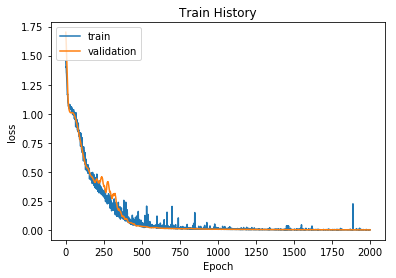

In [175]:
#劃出準確度歷程
import matplotlib.pyplot as plt
def show_tarin_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel("Epoch")
    plt.legend(['train','validation'],loc="upper left")
    plt.show()
show_tarin_history(train_history,'loss','val_loss')
# show_tarin_history(train_history,'loss','loss')

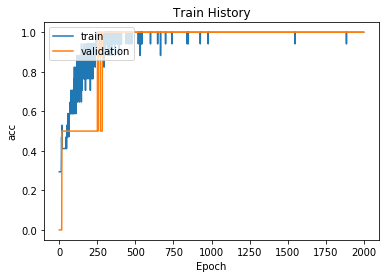

In [176]:
show_tarin_history(train_history,'acc','val_acc')

In [177]:
score=model.evaluate(xx_train,Y_trainO,verbose=1)
print('Train accuracy:',score[1])
score=model.evaluate(xx_test,Y_testO,verbose=1)
print('Test accuracy:',score[1])

19/19 [==============================] - 0s 263us/step
Train accuracy: 1.0
9/9 [==============================] - 0s 444us/step
Test accuracy: 0.6666666865348816


In [178]:
list(model.predict_classes(xx_test)==Y_test).count(True)/len(Y_test)

9/9 [==============================] - 0s 21ms/step


0.6666666666666666

In [179]:
model.predict_classes(xx_test)

9/9 [==============================] - 0s 444us/step


array([1, 1, 2, 0, 1, 2, 1, 0, 0], dtype=int64)

# 分群

# kmeans分群 (xx>>正規化後的feature)

如果直接用X(非正規化feature)則會變成按人口區分(因為人口的值特別高)

In [180]:
xx.shape

(28, 12)

In [181]:
Y.shape

(28,)

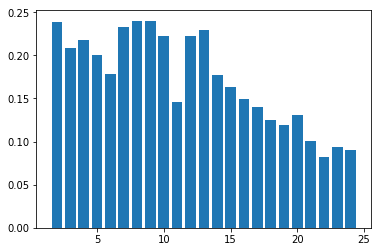

[0.23887871948380843, 0.2081246716673564, 0.21833080130926705, 0.20015727376164566, 0.17833643910101737, 0.2324241098984782, 0.23990897080668275, 0.24011323654867392, 0.22240891498927198, 0.14593823042099618, 0.22205600527134783, 0.2296199613945369, 0.17744412690615494, 0.16268852182099053, 0.14967356744226668, 0.1401923539326125, 0.12458009471117511, 0.11898957327642472, 0.13033740399767904, 0.10041851247034403, 0.08237533103438975, 0.09408583101972845, 0.09011860964281726]


In [185]:
from sklearn import cluster, datasets, metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# 印出效用最高的kmeans群
silhouette_avgs = []
ks = range(2, 25)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k,max_iter=3000).fit(xx)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(xx, cluster_labels) #組間變異
    silhouette_avgs.append(silhouette_avg)

# 作圖並印出 k = 2 到 30 的績效
plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)

In [193]:
k=8
km = KMeans(n_clusters=k,max_iter=3000)  #K=4群
y_pred = km.fit_predict(xx)

In [194]:
y_pred

array([1, 0, 5, 0, 1, 0, 1, 2, 6, 7, 2, 2, 2, 2, 2, 5, 5, 1, 2, 1, 4, 6,
       7, 1, 3, 3, 4, 4])

In [195]:
#利用PCA降維法、將feature印射在二維空間
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_xx = pca.fit_transform(xx)

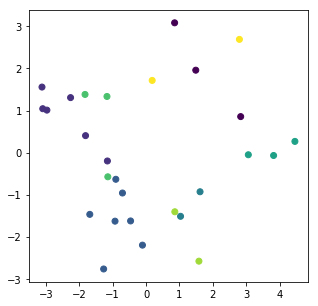

['costPower', 'human', 'simCostDien', 'busStation', 'conStore', 'star', 'mc', 'ken', 'wa', 'watson', 'pxmart', 'carrefour']
第0群資料中心
[0.66, -0.72, 1.25, 0.5, -0.28, 0.74, 1.43, -0.59, 1.93, -0.24, -0.42, -0.52]
第1群資料中心
[-0.31, -0.91, -1.04, -0.82, -1.1, -0.78, -0.59, -0.59, -0.64, -0.75, -1.13, -0.52]
第2群資料中心
[-0.55, 1.01, -0.41, -0.06, 0.2, -0.65, -0.51, -0.59, -0.64, -0.15, 0.65, -0.52]
第3群資料中心
[-1.12, 1.01, -0.09, 1.06, 1.11, 0.13, -0.04, 1.05, 0.64, -0.07, 0.65, 1.91]
第4群資料中心
[0.07, -0.69, 1.71, 1.23, 1.56, 1.66, 1.43, 0.51, 0.64, 1.46, 0.65, -0.52]
第5群資料中心
[1.6, -0.14, -0.39, -0.09, -0.97, -0.78, -0.41, -0.04, -0.64, -0.58, 0.29, 1.91]
第6群資料中心
[-0.05, 1.28, 0.4, -0.62, 1.18, 1.05, -0.59, 0.23, -0.64, 1.97, 0.65, -0.52]
第7群資料中心
[0.54, -0.8, 0.36, -0.23, -0.18, 1.05, 0.51, 2.69, 1.28, -0.07, -0.95, 0.7]


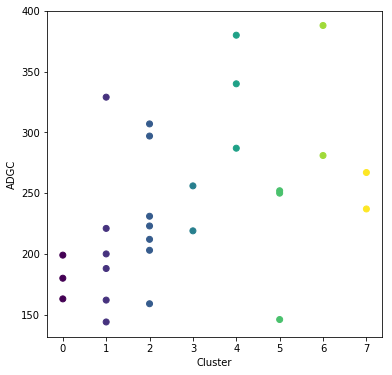

In [196]:
plt.figure(figsize=(5, 5))
# plt.xlabel('costPower')
# plt.ylabel('Nhuman')
# plt.scatter(xx[:, 0], xx[:, 1], c=y_pred) #C是第三維度 已顏色做維度
plt.scatter(reduced_xx.T[0], reduced_xx.T[1], c=y_pred)
plt.legend()
plt.show()


print([i.replace("_Analyze","").replace("N","") for i in ['costPower_Analyze','Nhuman_Analyze',"NsimCostDien",
        'NbusStation_Analyze','NconStore_Analyze','Nstar_Analyze',
        'Nmc_Analyze', 'Nken_Analyze','Nwa_Analyze',
        'Nwatson_Analyze','Npxmart_Analyze','Ncarrefour_Analyze']])
x=0
for i in np.around(km.cluster_centers_,2):
    print("第{}群資料中心".format(x),list(i),sep="\n")
    x+=1
plt.figure(figsize=(6, 6))
plt.xlabel('Cluster')
plt.ylabel('ADGC')
plt.scatter(y_pred, Y, c=y_pred) #C是第三維度 已顏色做維度
plt.show()

In [197]:
CY=df['costPower_Analyze'].values
HY=df['Nhuman_Analyze'].values

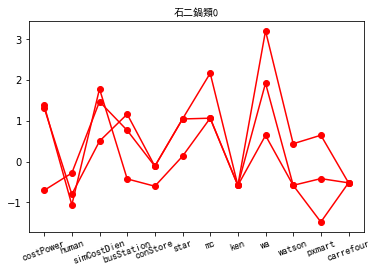

[180, 199, 163]
[89.0, 90.0, 55.0]
[11286, 8109, 17700]
[(180, 89.0, 11286), (199, 90.0, 8109), (163, 55.0, 17700)]


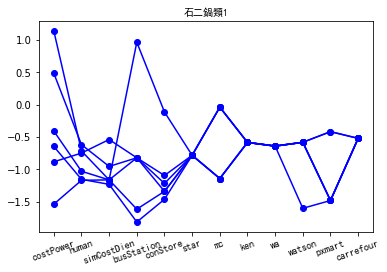

[162, 221, 188, 144, 200, 329]
[86.0, 52.0, 60.0, 41.0, 56.0, 75.0]
[12346, 11943, 8488, 6767, 6956, 13549]
[(162, 86.0, 12346), (221, 52.0, 11943), (188, 60.0, 8488), (144, 41.0, 6767), (200, 56.0, 6956), (329, 75.0, 13549)]


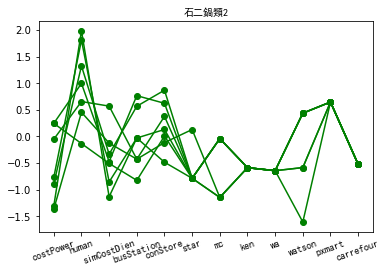

[223, 203, 231, 297, 159, 307, 212]
[45.0, 71.0, 54.0, 66.0, 44.0, 52.0, 71.0]
[45508, 19529, 43388, 29217, 26741, 37422, 33394]
[(223, 45.0, 45508), (203, 71.0, 19529), (231, 54.0, 43388), (297, 66.0, 29217), (159, 44.0, 26741), (307, 52.0, 37422), (212, 71.0, 33394)]


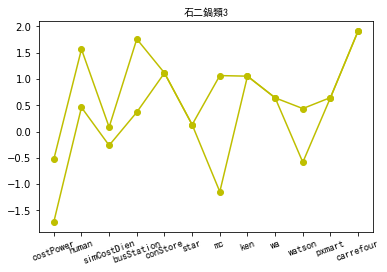

[256, 219]
[38.0, 58.0]
[26811, 40403]
[(256, 38.0, 26811), (219, 58.0, 40403)]


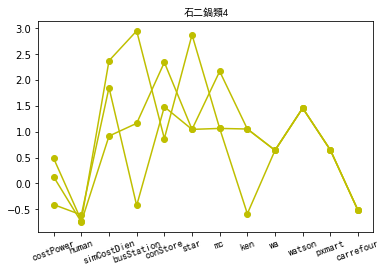

[287, 340, 380]
[75.0, 69.0, 60.0]
[12352, 12000, 13684]
[(287, 75.0, 12352), (340, 69.0, 12000), (380, 60.0, 13684)]


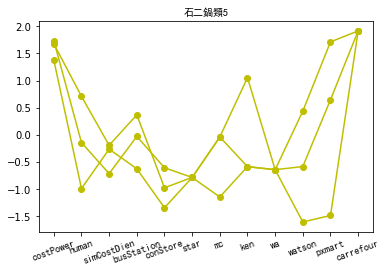

[146, 252, 250]
[96.0, 95.0, 90.0]
[19420, 29884, 9021]
[(146, 96.0, 19420), (252, 95.0, 29884), (250, 90.0, 9021)]


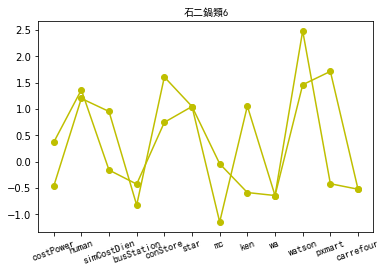

[281, 388]
[73.0, 59.0]
[37878, 35880]
[(281, 73.0, 37878), (388, 59.0, 35880)]


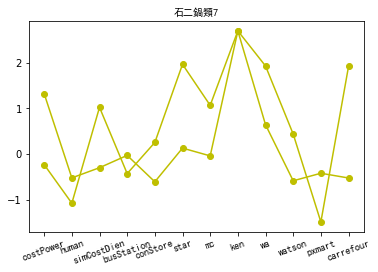

[267, 237]
[89.0, 63.0]
[14771, 7974]
[(267, 89.0, 14771), (237, 63.0, 7974)]


In [202]:
xlabels=[i.replace("_Analyze","").replace("N","") for i in ['costPower_Analyze','Nhuman_Analyze',"NsimCostDien",
        'NbusStation_Analyze','NconStore_Analyze','Nstar_Analyze',
        'Nmc_Analyze', 'Nken_Analyze','Nwa_Analyze',
        'Nwatson_Analyze','Npxmart_Analyze','Ncarrefour_Analyze']]
style = ['o-r', 'o-b', 'o-g','o-y','o-y','o-y','o-y','o-y']
for i in range(k):
    plt.figure()
    aa=[]
    bb=[]
    cc=[]
    abc=[]
    for j,x,a,b,c in zip(y_pred,xx,Y,CY,HY):
        if j==i:
            plt.plot(range(1, len(xx[0])+1), x, style[i],)
            plt.xticks(range(1, len(xx[0])+1), xlabels, rotation = 20,fontproperties='SimHei') #坐标标签
            plt.title(u'石二鍋類%s' %(i),fontproperties='SimHei') #我们计数习惯从1开始
            plt.subplots_adjust(bottom=0.15) #调整底部
            aa.append(a)
            bb.append(b)
            cc.append(c)
            abc.append((a,b,c))
    plt.show()
    print(aa)
    print(bb)
    print(cc)
    print(abc)

In [192]:
len([304, 362, 299, 377, 329, 349, 289, 302, 362, 251, 292])
len([91621, 286210, 34601, 164362, 179901, 116244, 100319, 154917, 111510, 83174, 67165])

11

# Agglomerative分群

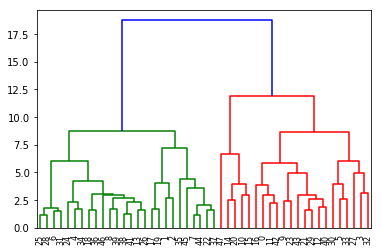

In [103]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage,dendrogram
#這裡使用scipy的層次聚類函數
Z = linkage(xx, method = 'ward', metric = 'euclidean') #譜系聚類圖
P = dendrogram(Z, 0) #畫譜系聚類圖
plt.show()

In [104]:
from sklearn.cluster import AgglomerativeClustering #導入sklearn的層次聚類函數
model = AgglomerativeClustering(n_clusters = k, linkage = 'ward')
model.fit(xx)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func=<function mean at 0x000000000737E158>)

In [105]:
model.labels_

array([0, 1, 1, 0, 3, 0, 3, 1, 3, 0, 2, 0, 0, 3, 2, 2, 0, 1, 3, 1, 2, 0,
       1, 0, 3, 3, 3, 0, 3, 0, 0, 3, 0, 0, 3, 1, 3, 1, 3, 3, 0, 3, 0, 0,
       1, 1, 3, 2], dtype=int64)

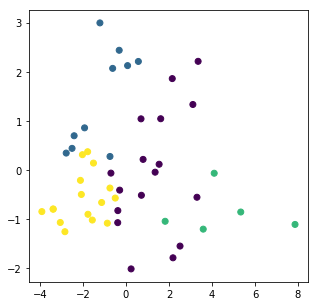

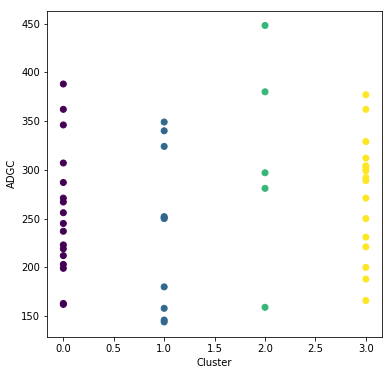

In [106]:
plt.figure(figsize=(5, 5))
# plt.xlabel('costPower')
# plt.ylabel('Nhuman')
# plt.scatter(xx[:, 0], xx[:, 1], c=y_pred) #C是第三維度 已顏色做維度
plt.scatter(reduced_xx.T[0], reduced_xx.T[1], c=model.labels_)
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.xlabel('Cluster')
plt.ylabel('ADGC')
plt.scatter(model.labels_, Y, c=model.labels_) #C是第三維度 已顏色做維度
plt.show()